# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [2]:
import pandas as pd
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2024-11-18 16:26:24,533 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_simulated_weekly.csv"
)

dt_prophet_holidays = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_prophet_holidays.csv"
)

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00


,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [7]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-11-18 16:26:26,687 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-11-18 16:26:26,689 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-11-18 16:26:26,690 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2024-11-18 16:26:27,353 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/tmpum2qm5j2/cmx6mpqs.json
2024-11-18 16:26:27,411 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnw

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt
%matplotlib inline

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters, featurized_mmmdata=featurized_mmm_data)
# Extract the list of results
results_list = featurized_mmm_data.modNLS["results"]
# Plot spend-exposure relationship for each channel in the results
for result in results_list:
    channel = result["channel"]
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

2024-11-18 16:26:27,639 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-18 16:26:27,640 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-18 16:26:27,640 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-11-18 16:26:27,640 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: FeaturizedMMMData(dt_mod=            ds       dep_var         trend        season       holiday  \
0   2015-11-23  2.754372e+06  1.716264e+06  1.133548e+06       0.00000   
1   2015-11-30  2.584277e+06  1.717329e+06  8.990713e+05       0.00000   
2   2015-12-07  2.547387e+06  1.718393e+06  7.075011e+05       0.00000   
3   2015-12-14  2.875220e+06  1.719458e+06  6.933337e+05       0.00000   
4   2015-12-21  2.215953e+06  1.720523e+06  8.031644e+05  483714.32256   
..         ...           ...           ...           ...           ...   
203 2

Skipping facebook_I: No spend-exposure data available for channel: FeaturizedMMMData(dt_mod=            ds       dep_var         trend        season       holiday  \
0   2015-11-23  2.754372e+06  1.716264e+06  1.133548e+06       0.00000   
1   2015-11-30  2.584277e+06  1.717329e+06  8.990713e+05       0.00000   
2   2015-12-07  2.547387e+06  1.718393e+06  7.075011e+05       0.00000   
3   2015-12-14  2.875220e+06  1.719458e+06  6.933337e+05       0.00000   
4   2015-12-21  2.215953e+06  1.720523e+06  8.031644e+05  483714.32256   
..         ...           ...           ...           ...           ...   
203 2019-10-14  2.456240e+06  1.743483e+06  7.429261e+05       0.00000   
204 2019-10-21  2.182825e+06  1.742720e+06  7.979784e+05       0.00000   
205 2019-10-28  2.377707e+06  1.741957e+06  8.621816e+05       0.00000   
206 2019-11-04  2.732825e+06  1.741194e+06  1.003188e+06       0.00000   
207 2019-11-11  2.767788e+06  1.740432e+06  1.171096e+06       0.00000   

     competitor_sal

2024-11-18 16:26:27,726 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-11-18 16:26:27,728 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-11-18 16:26:27,728 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-11-18 16:26:27,728 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-11-18 16:26:27,729 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-11-18 16:26:27,729 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-11-18 16:26:27,730 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-11-18 16:26:27,730 - robyn.modeling.ridge_model_builder - INFO - Collecting hyperparameters for optimization...


>>> Starting 5 trials with 54 iterations each using TwoPointsDE nevergrad algorithm on...


Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-11-18 16:26:30,124 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.04 mins
Running trial 2 of total 5 trials: 100%|███████████████████████████████████
2024-11-18 16:26:32,397 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.04 mins
Running trial 3 of total 5 trials: 100%|███████████████████████████████████
2024-11-18 16:26:34,658 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.04 mins
Running trial 4 of total 5 trials: 100%|███████████████████████████████████
2024-11-18 16:26:37,437 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.05 mins
Running trial 5 of total 5 trials: 100%|███████████████████████████████████
2024-11-18 16:26:40,110 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.04 mins
2024-11-18 16:26:40,120 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer
2024-11-18 16:26:40,121 - robyn.

Model training complete.


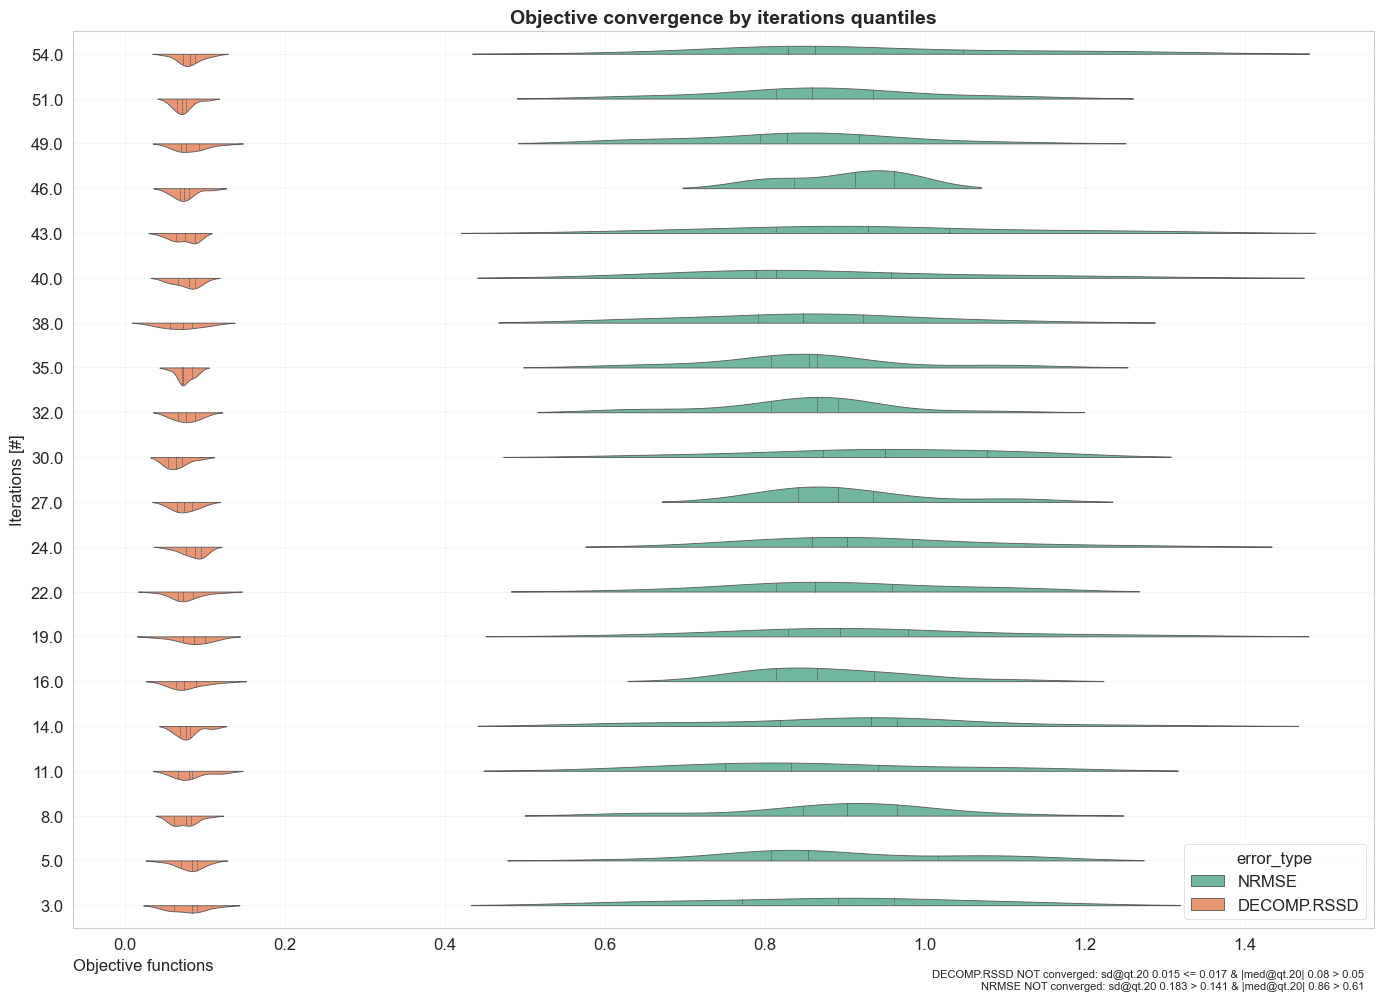

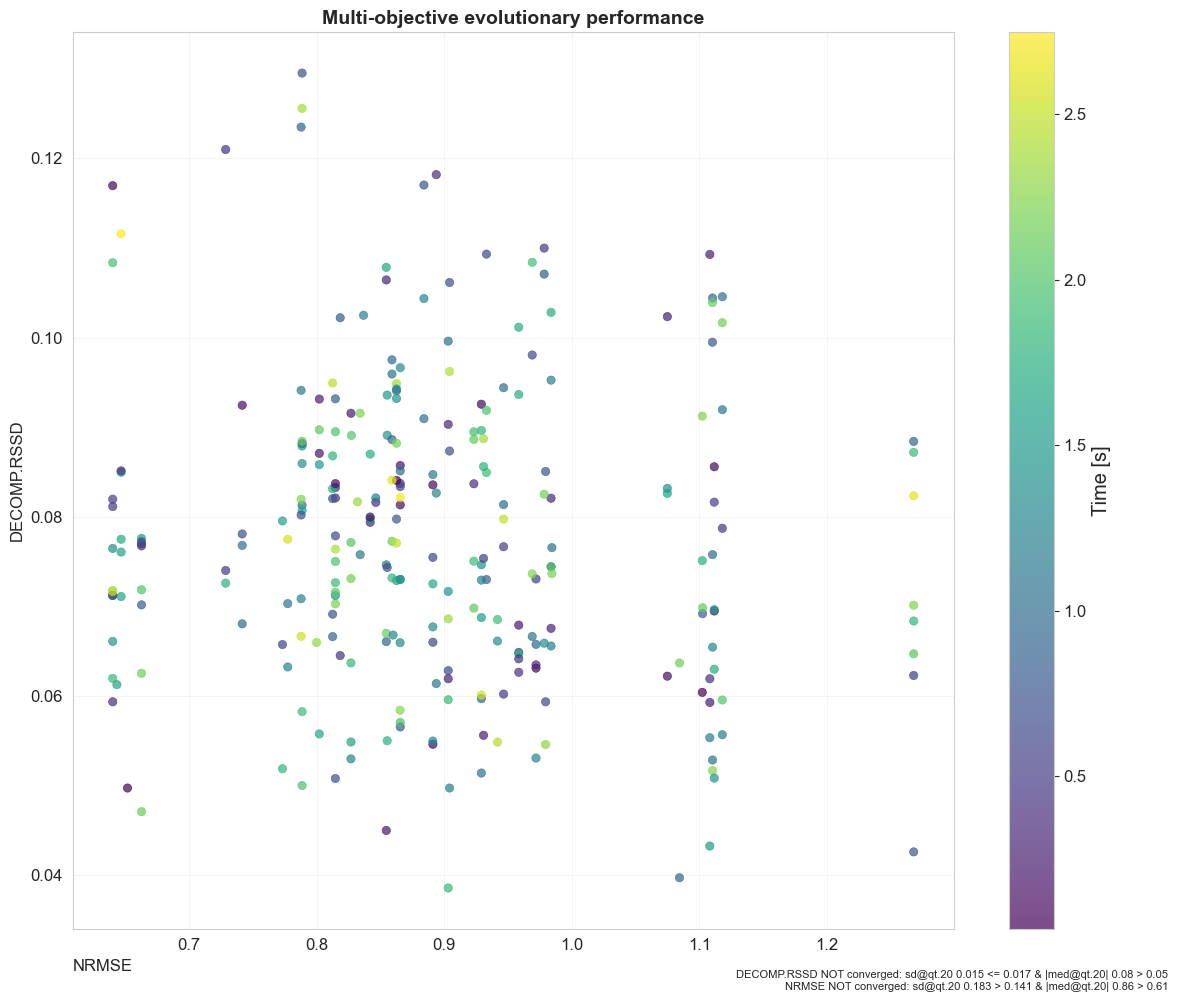

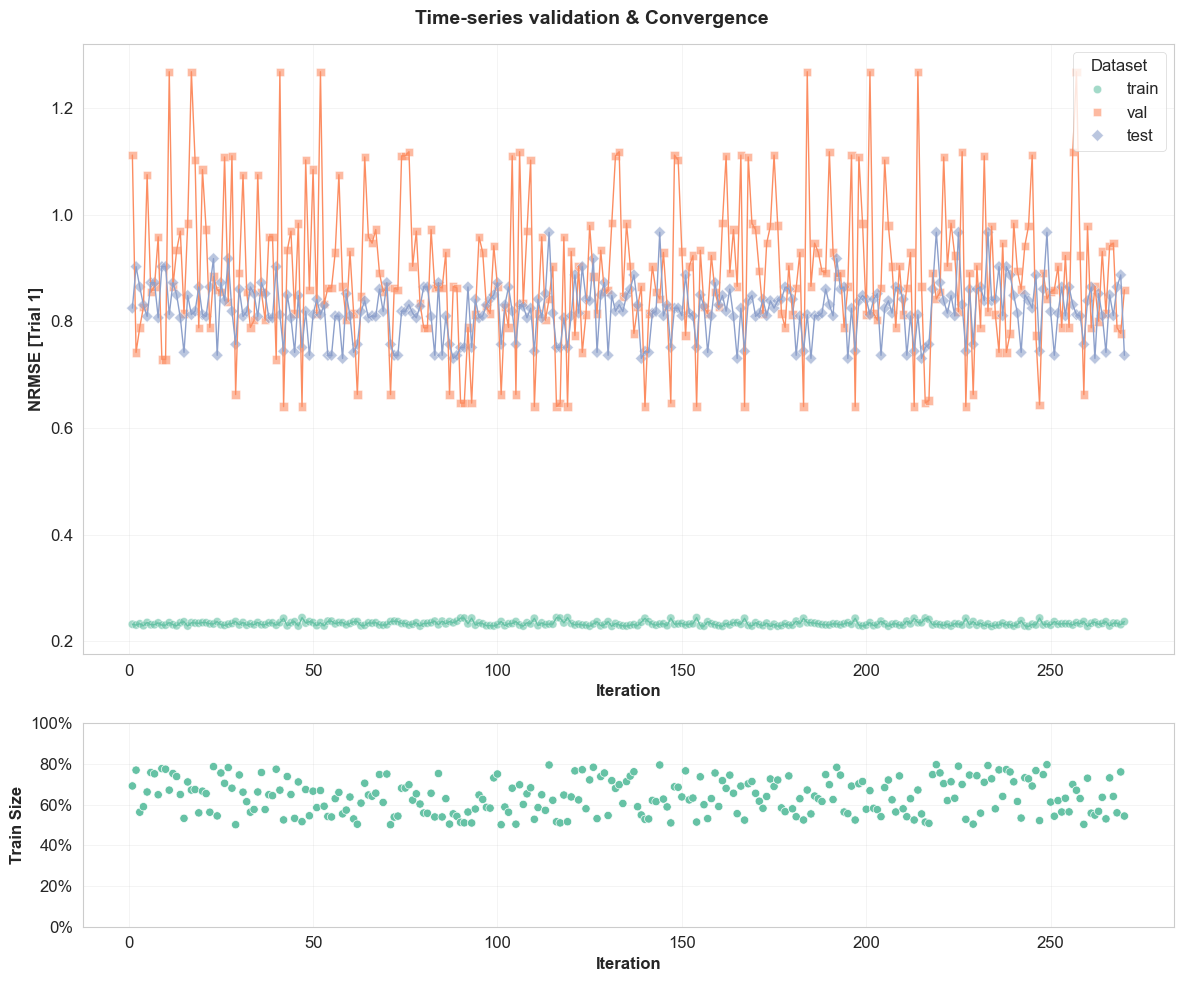

In [9]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(iterations=54, trials=5)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

In [10]:
best_model_id = output_models.select_id
print(f"Best model ID: {best_model_id}")

Best model ID: 3_1_1


In [13]:
# Add after model training
print("Model Output Summary:")
print(f"Number of trials: {len(output_models.trials)}")
print(f"Average models per trial: {len(output_models.all_result_hyp_param) / len(output_models.trials)}")
print(f"Total unique models: {len(output_models.all_result_hyp_param['sol_id'].unique())}")

print("\nMetrics Distribution:")
metrics_df = output_models.all_result_hyp_param[["nrmse", "decomp.rssd", "mape"]]
print(metrics_df.describe())

# Additional validation to debug model output
print("\nColumns in result_hyp_param:")
print(output_models.all_result_hyp_param.columns.tolist())

print("\nSample rows of metrics:")
print(output_models.all_result_hyp_param[["sol_id", "nrmse", "decomp.rssd", "mape"]].head())

# Show shape of result dataframes
print("\nDataFrame Shapes:")
print(f"result_hyp_param: {output_models.all_result_hyp_param.shape}")
print(f"x_decomp_agg: {output_models.all_x_decomp_agg.shape}")
print(f"decomp_spend_dist: {output_models.all_decomp_spend_dist.shape}")

Model Output Summary:
Number of trials: 5
Average models per trial: 54.0
Total unique models: 270

Metrics Distribution:
            nrmse  decomp.rssd   mape
count  270.000000   270.000000  270.0
mean     0.891068     0.077636    0.0
std      0.140952     0.016628    0.0
min      0.640237     0.038562    0.0
25%      0.812554     0.065975    0.0
50%      0.865549     0.076609    0.0
75%      0.966307     0.088101    0.0
max      1.267842     0.129534    0.0

Columns in result_hyp_param:
['facebook_S_thetas', 'facebook_S_alphas', 'facebook_S_gammas', 'print_S_thetas', 'print_S_alphas', 'print_S_gammas', 'tv_S_thetas', 'tv_S_alphas', 'tv_S_gammas', 'search_S_thetas', 'search_S_alphas', 'search_S_gammas', 'ooh_S_thetas', 'ooh_S_alphas', 'ooh_S_gammas', 'newsletter_thetas', 'newsletter_alphas', 'newsletter_gammas', 'lambda', 'train_size', 'sol_id', 'Elapsed', 'ElapsedAccum', 'pos', 'trial', 'rsq_train', 'rsq_val', 'rsq_test', 'nrmse', 'nrmse_train', 'nrmse_val', 'nrmse_test', 'decomp.rssd

In [14]:
from robyn.modeling.pareto.pareto_optimizer import ParetoOptimizer
%load_ext autoreload
%autoreload 2

In [15]:
# 3. Create ParetoOptimizer instance
pareto_optimizer = ParetoOptimizer(mmm_data, output_models, hyperparameters, featurized_mmm_data, holidays_data)

In [16]:
# 4. Run optimize function
pareto_result = pareto_optimizer.optimize(pareto_fronts="auto", min_candidates=100)

2024-11-18 16:27:22 [INFO] Starting Pareto optimization
2024-11-18 16:27:22 [INFO] Starting model data aggregation
2024-11-18 16:27:22 [INFO] Computing Pareto fronts
2024-11-18 16:27:22 [INFO] Pareto front computation completed
2024-11-18 16:27:22 [INFO] Preparing Pareto data
2024-11-18 16:27:22 [INFO] Number of Pareto-optimal solutions found: 220
2024-11-18 16:27:22 [INFO] Selected 10 Pareto-fronts containing 103 candidates
2024-11-18 16:27:22 [INFO] Filtering data for selected Pareto fronts...
2024-11-18 16:27:22 [INFO] Calculating response curves for 515 models' media variables...
2024-11-18 16:27:22,646 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,658 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


==== Preparing Pareto Data Debug Outputs ====
Result Hyp Param Columns:  Index(['facebook_S_thetas', 'facebook_S_alphas', 'facebook_S_gammas',
       'print_S_thetas', 'print_S_alphas', 'print_S_gammas', 'tv_S_thetas',
       'tv_S_alphas', 'tv_S_gammas', 'search_S_thetas', 'search_S_alphas',
       'search_S_gammas', 'ooh_S_thetas', 'ooh_S_alphas', 'ooh_S_gammas',
       'newsletter_thetas', 'newsletter_alphas', 'newsletter_gammas', 'lambda',
       'train_size', 'sol_id', 'Elapsed', 'ElapsedAccum', 'pos', 'trial',
       'rsq_train', 'rsq_val', 'rsq_test', 'nrmse', 'nrmse_train', 'nrmse_val',
       'nrmse_test', 'decomp.rssd', 'mape', 'lambda_hp', 'lambda_max',
       'lambda_min_ratio', 'iterNG', 'iterPar', 'iterations', 'coef',
       'mape.qt10', 'robynPareto', 'error_score'],
      dtype='object')
Result Hyp Param Shape:  (270, 44)
Result Hyp Param Sample:     facebook_S_thetas  facebook_S_alphas  facebook_S_gammas  print_S_thetas  \
0           0.283596           1.843564      

2024-11-18 16:27:22,681 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:   0%|          | 0/515 [00:00<?, ?it/s]2024-11-18 16:27:22,685 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,690 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,707 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,726 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,738 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bo


Error processing row for sol_id 1_2_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_2_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_2_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_10_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_10_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_10_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_10_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:22,765 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,777 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,788 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:   3%|▎         | 13/515 [00:00<00:04, 121.72it/s]2024-11-18 16:27:22,799 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,809 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,820 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 1_10_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_15_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_15_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_15_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_15_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_15_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_20_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_20_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_20_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_20_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:22,884 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,895 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,907 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,919 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,930 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,942 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:   5%|▌     

Error processing row for sol_id 1_25_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_25_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_25_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_25_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_26_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_26_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_26_1, rn print_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:22,977 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:22,989 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,001 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,012 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,023 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,033 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,044 - ro

Error processing row for sol_id 1_26_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_26_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_29_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_29_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_29_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_29_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_29_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_30_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_30_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_30_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:23,100 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 1_30_1, rn search_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:23,112 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,124 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,135 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,146 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,158 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 1_37_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_37_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_37_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_37_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_37_1, rn search_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:23,169 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,180 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:   9%|▉         | 47/515 [00:00<00:07, 66.33it/s]

Error processing row for sol_id 1_40_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_40_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:23,191 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 1_40_1, rn print_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:23,203 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,213 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,225 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,294 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,366 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,381 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,398 - ro

Error processing row for sol_id 1_40_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_40_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_42_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_42_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_42_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_42_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_42_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_45_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_45_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_45_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:23,472 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,483 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,495 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  12%|█▏        | 63/515 [00:00<00:06, 68.96it/s]

Error processing row for sol_id 1_47_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_47_1, rn print_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:23,506 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 1_47_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:23,518 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,529 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,541 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,574 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,588 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,601 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,613 - ro

Error processing row for sol_id 1_47_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_51_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_51_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_51_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_51_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 1_51_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_6_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_6_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_6_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_6_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error 

2024-11-18 16:27:23,715 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,727 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,737 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  16%|█▌        | 82/515 [00:01<00:05, 78.32it/s]

Error processing row for sol_id 2_8_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_14_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_14_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:23,748 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 2_14_1, rn print_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:23,760 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,770 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,781 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,793 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,805 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,815 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,826 - ro

Error processing row for sol_id 2_14_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_14_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_15_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_15_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_15_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_15_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_15_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_16_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_16_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_16_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:23,923 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,934 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,946 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  19%|█▉        | 100/515 [00:01<00:05, 81.65it/s]

Error processing row for sol_id 2_17_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_17_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_17_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_25_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:23,956 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,968 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 2_25_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:23,979 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:23,991 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,009 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,013 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,023 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,034 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,046 - ro

Error processing row for sol_id 2_25_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_25_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_25_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_26_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_26_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_26_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_26_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_26_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_27_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_27_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:24,127 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,138 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,149 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,162 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  23%|██▎       | 119/515 [00:01<00:04, 85.06it/s]2024-11-18 16:27:24,172 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 2_28_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_28_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_28_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_28_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_28_1, rn search_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:24,184 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,196 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,207 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,219 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,231 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,242 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,254 - ro

Error processing row for sol_id 2_33_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_33_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_33_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_33_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_33_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_34_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_34_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_34_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_34_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_34_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:24,343 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,354 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  27%|██▋       | 137/515 [00:01<00:04, 87.27it/s]2024-11-18 16:27:24,365 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,376 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,387 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,398 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 2_35_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_36_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_36_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_36_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_36_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_36_1, rn search_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:24,409 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,420 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,431 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,444 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,454 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  28%|██▊       | 146/515 [00:01<00:04, 87.33it/s]2024-11-18 16:27:24,464 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 2_37_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_37_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_37_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_37_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_37_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_38_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_38_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_38_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_38_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_38_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:24,546 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,558 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,570 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  30%|███       | 155/515 [00:01<00:04, 87.54it/s]2024-11-18 16:27:24,581 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,592 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,603 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 2_39_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_39_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_43_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_43_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_43_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_43_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:24,615 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,625 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,636 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,648 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,658 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,669 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  32%|███▏  

Error processing row for sol_id 2_43_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_44_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_44_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_44_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_44_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_44_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_46_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_46_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_46_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_46_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:24,752 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,766 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,779 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  34%|███▎      | 173/515 [00:02<00:04, 84.16it/s]2024-11-18 16:27:24,792 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,804 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,815 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 2_47_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_47_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_47_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_47_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_47_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_48_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_48_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:24,839 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,849 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,861 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,873 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,884 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  35%|███▌      | 182/515 [00:02<00:03, 85.38it/s]2024-11-18 16:27:24,895 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 2_48_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_48_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_48_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_51_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_51_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_51_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_51_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 2_51_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_8_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:24,940 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,951 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,962 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,974 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:24,985 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  37%|███▋      | 191/515 [00:02<00:04, 76.69it/s]2024-11-18 16:27:24,996 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 3_8_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_8_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_8_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_8_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_9_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_9_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:25,059 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,071 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,085 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,096 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,107 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,119 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,130 - ro

Error processing row for sol_id 3_9_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_9_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_9_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_11_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_11_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_11_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_11_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_11_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_13_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_13_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error

2024-11-18 16:27:25,201 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,213 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,224 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,235 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,246 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  41%|████      | 210/515 [00:02<00:03, 82.84it/s]2024-11-18 16:27:25,257 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 3_13_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_14_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_14_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_14_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_14_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_14_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_15_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:25,279 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,290 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,301 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,312 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,323 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,334 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,345 - ro

Error processing row for sol_id 3_15_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_15_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_15_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_15_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_16_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_16_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_16_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_16_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_16_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_21_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:25,410 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,421 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,432 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,443 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,453 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  44%|████▍     | 229/515 [00:02<00:03, 85.47it/s]2024-11-18 16:27:25,465 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 3_21_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_28_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_28_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_28_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_28_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_28_1, rn search_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:25,477 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,488 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,499 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,511 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,525 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,537 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,547 - ro

Error processing row for sol_id 3_29_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_29_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_29_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_29_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_29_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_30_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_30_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_30_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_30_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_30_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:25,624 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,635 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,645 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,657 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,667 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,678 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,688 - ro

Error processing row for sol_id 3_31_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_31_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_32_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_32_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_32_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_32_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_32_1, rn search_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:25,699 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,710 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,720 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,731 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,742 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,752 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,762 - ro

Error processing row for sol_id 3_33_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_33_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_33_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_33_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_33_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_38_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_38_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_38_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_38_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_38_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:25,840 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,852 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,863 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,874 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,886 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,898 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,909 - ro

Error processing row for sol_id 3_39_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_39_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_43_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_43_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_43_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_43_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:25,920 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,930 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,941 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,952 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,963 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,973 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:25,984 - ro

Error processing row for sol_id 3_43_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_44_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_44_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_44_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_44_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_44_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_49_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_49_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_49_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_49_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:26,058 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,068 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,079 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,089 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,099 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,117 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  56%|█████▌

Error processing row for sol_id 3_51_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_51_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_52_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_52_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_52_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_52_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 3_52_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:26,142 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,152 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,163 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,173 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,183 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,194 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,204 - ro

Error processing row for sol_id 4_1_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_1_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_1_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_1_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_1_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_5_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_5_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_5_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_5_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_5_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error proces

2024-11-18 16:27:26,277 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,288 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,298 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,308 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,319 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  60%|██████    | 309/515 [00:03<00:02, 94.69it/s]2024-11-18 16:27:26,329 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 4_6_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_14_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_14_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_14_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_14_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_14_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_15_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:26,350 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,360 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,371 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,381 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,391 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,402 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,412 - ro

Error processing row for sol_id 4_15_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_15_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_15_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_15_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_20_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_20_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_20_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_20_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_20_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_21_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:26,495 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,506 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,516 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,527 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  64%|██████▍   | 329/515 [00:03<00:01, 94.90it/s]2024-11-18 16:27:26,537 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,548 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 4_25_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_25_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_25_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_25_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_25_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_26_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:26,570 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,581 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,592 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,602 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,612 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,623 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,634 - ro

Error processing row for sol_id 4_26_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_26_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_26_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_26_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_31_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_31_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_31_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_31_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_31_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_33_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:26,697 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,709 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,722 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,746 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,762 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 4_33_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_33_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_35_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_35_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_35_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_35_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0


Processing rows:  68%|██████▊   | 349/515 [00:04<00:01, 85.86it/s]2024-11-18 16:27:26,776 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,787 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,798 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,811 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,822 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,834 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 4_35_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_36_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_36_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_36_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_36_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_36_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_44_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_44_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_44_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_44_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:26,936 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,947 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,958 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,968 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,980 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:26,991 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 4_45_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_45_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_45_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_50_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_50_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_50_1, rn print_S: index 0 is out of bounds for axis 0 with size 0


Processing rows:  72%|███████▏  | 369/515 [00:04<00:01, 88.83it/s]2024-11-18 16:27:27,002 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,012 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,024 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,036 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,047 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,057 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 4_50_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_50_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_51_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_51_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_51_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_51_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 4_51_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_1_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_1_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_1_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error

2024-11-18 16:27:27,148 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,160 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,172 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,184 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 5_4_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_4_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_4_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_4_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_6_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:27,195 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,207 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  75%|███████▌  | 387/515 [00:04<00:01, 85.57it/s]2024-11-18 16:27:27,218 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,231 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,244 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,260 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 5_6_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_6_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_6_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_6_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_9_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_9_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_9_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_9_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_9_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_11_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error proce

2024-11-18 16:27:27,358 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,369 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,380 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,391 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,401 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,413 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 5_11_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_13_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_13_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_13_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_13_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0


Processing rows:  79%|███████▊  | 405/515 [00:04<00:01, 84.90it/s]2024-11-18 16:27:27,426 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,437 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,448 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,461 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,472 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,484 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 5_13_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_15_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_15_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_15_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_15_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_15_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_19_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_19_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_19_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_19_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:27,577 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,588 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,601 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,613 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,625 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 5_20_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_20_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_22_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_22_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_22_1, rn print_S: index 0 is out of bounds for axis 0 with size 0


Processing rows:  82%|████████▏ | 423/515 [00:04<00:01, 86.21it/s]2024-11-18 16:27:27,637 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,648 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,659 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,670 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,682 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 5_22_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_22_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_23_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_23_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:27,693 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,704 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,715 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,854 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 5_23_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_23_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_23_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_26_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0


Processing rows:  84%|████████▍ | 432/515 [00:05<00:01, 64.26it/s]2024-11-18 16:27:27,857 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,872 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,885 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,896 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,907 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:27,918 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 5_26_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_26_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_26_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_26_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_30_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_30_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_30_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_30_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_30_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_31_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:28,044 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,054 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,064 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 5_32_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_32_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_34_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_34_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0


Processing rows:  88%|████████▊ | 452/515 [00:05<00:00, 77.93it/s]2024-11-18 16:27:28,074 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,084 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,095 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,106 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,116 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,127 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is

Error processing row for sol_id 5_34_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_34_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_34_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_35_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_35_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_35_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_35_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_35_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_36_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_36_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:28,253 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,264 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,274 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,284 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  92%|█████████▏| 472/515 [00:05<00:00, 84.82it/s]

Error processing row for sol_id 5_37_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_37_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_39_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_39_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:28,295 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,305 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,316 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,327 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,338 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,350 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,361 - ro

Error processing row for sol_id 5_39_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_39_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_39_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_43_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_43_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_43_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_43_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_43_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_45_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_45_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:28,469 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,479 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,490 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
Processing rows:  96%|█████████▌| 492/515 [00:05<00:00, 89.73it/s]2024-11-18 16:27:28,501 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0


Error processing row for sol_id 5_46_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_46_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_47_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_47_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0


2024-11-18 16:27:28,511 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,529 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,532 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,543 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,554 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,564 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,575 - ro

Error processing row for sol_id 5_47_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_47_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_47_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_49_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_49_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_49_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_49_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_49_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_50_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_50_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Er

2024-11-18 16:27:28,675 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,686 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,698 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,709 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,720 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,732 - robyn.modeling.pareto.response_curve - ERROR - Error calculating final response values: index 0 is out of bounds for axis 0 with size 0
2024-11-18 16:27:28,744 - ro

Error processing row for sol_id 5_52_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_52_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_53_1, rn tv_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_53_1, rn ooh_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_53_1, rn print_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_53_1, rn facebook_S: index 0 is out of bounds for axis 0 with size 0
Error processing row for sol_id 5_53_1, rn search_S: index 0 is out of bounds for axis 0 with size 0
Keys in aggregated_data:
['result_hyp_param', 'x_decomp_agg', 'result_calibration']


Processing Solutions: 0solution [00:00, ?solution/s]
2024-11-18 16:27:28 [INFO] Processing Pareto front 2
2024-11-18 16:27:28 [INFO] Pareto-Front: 2 [0 models]
Processing Solutions: 0solution [00:00, ?solution/s]
2024-11-18 16:27:28 [INFO] Processing Pareto front 3
2024-11-18 16:27:28 [INFO] Pareto-Front: 3 [0 models]
Processing Solutions: 0solution [00:00, ?solution/s]
2024-11-18 16:27:28 [INFO] Processing Pareto front 4
2024-11-18 16:27:28 [INFO] Pareto-Front: 4 [0 models]
Processing Solutions: 0solution [00:00, ?solution/s]
2024-11-18 16:27:28 [INFO] Processing Pareto front 5
2024-11-18 16:27:28 [INFO] Pareto-Front: 5 [0 models]
Processing Solutions: 0solution [00:00, ?solution/s]
2024-11-18 16:27:28 [INFO] Processing Pareto front 6
2024-11-18 16:27:28 [INFO] Pareto-Front: 6 [0 models]
Processing Solutions: 0solution [00:00, ?solution/s]
2024-11-18 16:27:28 [INFO] Processing Pareto front 7
2024-11-18 16:27:28 [INFO] Pareto-Front: 7 [0 models]
Processing Solutions: 0solution [00:00, 

In [25]:
# 5. Check results
print("Pareto Optimization Results:")
print(f"Number of Pareto fronts: {pareto_result.pareto_solutions}")
print(f"MediaVecCollect: {pareto_result.media_vec_collect.shape, pareto_result.media_vec_collect}")
print("\Hyper parameter solutions:")
print(pareto_result.result_hyp_param)

print("\nAggregated decomposition results:")
print(pareto_result.x_decomp_agg)
print("\result Calibration:")
print(pareto_result.result_calibration)
print("\nx Decomp Vec Collect:")
print(pareto_result.x_decomp_vec_collect.shape, pareto_result.x_decomp_vec_collect)
print("\nCarryover percentage all:")
print(pareto_result.df_caov_pct_all.shape, pareto_result.df_caov_pct_all)
print("\Plot Data Collected")
print("NUMBER OF PLOTS Data collected for:", len(pareto_result.plot_data_collect))
print("Plot data for solid 5_221_9", pareto_result.plot_data_collect)

# 6. Validate logic
assert pareto_result.pareto_fronts == "auto" or isinstance(
    pareto_result.pareto_fronts, int
), "Invalid pareto_fronts value"
assert not pareto_result.result_hyp_param.empty, "Empty result_hyp_param DataFrame"
assert not pareto_result.x_decomp_agg.empty, "Empty x_decomp_agg DataFrame"

print("\nAll assertions passed. The optimize function is working as expected.")

Pareto Optimization Results:
Number of Pareto fronts: set()
MediaVecCollect: ((0, 0), Empty DataFrame
Columns: []
Index: [])
\Hyper parameter solutions:
     facebook_S_thetas  facebook_S_alphas  facebook_S_gammas  print_S_thetas  \
0             0.283596           1.843564           0.518895        0.347031   
1             0.102470           0.677168           0.367063        0.333238   
2             0.130170           0.683583           0.806549        0.292438   
3             0.209519           2.107668           0.390941        0.236971   
4             0.140576           2.693035           0.572054        0.176611   
..                 ...                ...                ...             ...   
265           0.256421           0.746821           0.801512        0.245181   
266           0.052607           2.371266           0.779008        0.175338   
267           0.273371           2.583180           0.345582        0.391040   
268           0.224161           2.152948      

In [26]:
len(pareto_result.pareto_solutions)

0

## Allocator

In [27]:
## Step 1: Setup and Import

# Import necessary Robyn classes
from robyn.allocator.entities.enums import OptimizationScenario, ConstrMode
from robyn.allocator.budget_allocator import BudgetAllocator
from robyn.allocator.entities.allocation_config import AllocationConfig
from robyn.allocator.entities.allocation_constraints import AllocationConstraints
from robyn.visualization.allocator_plotter import AllocationPlotter
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
print(pareto_result.result_hyp_param["sol_id"])

0       1_1_1
1       1_2_1
2       1_3_1
3       1_4_1
4       1_5_1
        ...  
265    5_50_1
266    5_51_1
267    5_52_1
268    5_53_1
269    5_54_1
Name: sol_id, Length: 270, dtype: object


In [29]:
# Make sure to use the correct model ID from your pareto results
available_models = pareto_result.result_hyp_param["sol_id"].unique()  # or 'solID' if that's the column name
print(f"Available models: {available_models}")
# Initialize allocator with a valid model ID
select_model = available_models[0]  # Use first available model

# Initialize budget allocator
allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    pareto_result=pareto_result,  # Get ParetoResult from import_output_collect()
    select_model=select_model,
)

2024-11-18 16:27:38,471 - robyn.allocator.budget_allocator - INFO - Initializing BudgetAllocator
2024-11-18 16:27:38,473 - robyn.allocator.media_response - INFO - Initializing MediaResponseParamsCalculator
2024-11-18 16:27:38,473 - robyn.allocator.allocation_optimizer - INFO - Initializing AllocationOptimizer
2024-11-18 16:27:38,474 - robyn.allocator.media_response - INFO - Starting media response parameters calculation for model 1_1_1
2024-11-18 16:27:38,475 - robyn.allocator.media_response - WARNING - No coefficient data found for facebook_S, using default coefficient of 1.0
2024-11-18 16:27:38,476 - robyn.allocator.media_response - WARNING - No coefficient data found for ooh_S, using default coefficient of 1.0
2024-11-18 16:27:38,476 - robyn.allocator.media_response - WARNING - No coefficient data found for print_S, using default coefficient of 1.0
2024-11-18 16:27:38,477 - robyn.allocator.media_response - WARNING - No coefficient data found for search_S, using default coefficient o

Available models: ['1_1_1' '1_2_1' '1_3_1' '1_4_1' '1_5_1' '1_6_1' '1_7_1' '1_8_1' '1_9_1'
 '1_10_1' '1_11_1' '1_12_1' '1_13_1' '1_14_1' '1_15_1' '1_16_1' '1_17_1'
 '1_18_1' '1_19_1' '1_20_1' '1_21_1' '1_22_1' '1_23_1' '1_24_1' '1_25_1'
 '1_26_1' '1_27_1' '1_28_1' '1_29_1' '1_30_1' '1_31_1' '1_32_1' '1_33_1'
 '1_34_1' '1_35_1' '1_36_1' '1_37_1' '1_38_1' '1_39_1' '1_40_1' '1_41_1'
 '1_42_1' '1_43_1' '1_44_1' '1_45_1' '1_46_1' '1_47_1' '1_48_1' '1_49_1'
 '1_50_1' '1_51_1' '1_52_1' '1_53_1' '1_54_1' '2_1_1' '2_2_1' '2_3_1'
 '2_4_1' '2_5_1' '2_6_1' '2_7_1' '2_8_1' '2_9_1' '2_10_1' '2_11_1'
 '2_12_1' '2_13_1' '2_14_1' '2_15_1' '2_16_1' '2_17_1' '2_18_1' '2_19_1'
 '2_20_1' '2_21_1' '2_22_1' '2_23_1' '2_24_1' '2_25_1' '2_26_1' '2_27_1'
 '2_28_1' '2_29_1' '2_30_1' '2_31_1' '2_32_1' '2_33_1' '2_34_1' '2_35_1'
 '2_36_1' '2_37_1' '2_38_1' '2_39_1' '2_40_1' '2_41_1' '2_42_1' '2_43_1'
 '2_44_1' '2_45_1' '2_46_1' '2_47_1' '2_48_1' '2_49_1' '2_50_1' '2_51_1'
 '2_52_1' '2_53_1' '2_54_1' '3_1_1' '3_2_1

## Run Different Optimization Scenarios

### Scenario 1: Default Max Response

In [30]:
# Create base constraints matching R example
channel_constraints = AllocationConstraints(
    channel_constr_low={
        "tv_S": 0.7,  # -30% from base
        "ooh_S": 0.7,
        "print_S": 0.7,
        "facebook_S": 0.7,
        "search_S": 0.7,
    },
    channel_constr_up={
        "tv_S": 1.2,  # +20% from base
        "ooh_S": 1.5,  # +50% from base
        "print_S": 1.5,
        "facebook_S": 1.5,
        "search_S": 1.5,
    },
    channel_constr_multiplier=3.0,
)

# Configure max response scenario
max_response_config = AllocationConfig(
    scenario=OptimizationScenario.MAX_RESPONSE,
    constraints=channel_constraints,
    date_range="last",  # Use last period as initial
    total_budget=None,  # Use historical budget
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run optimization
result = allocator.allocate(max_response_config)

# Print results
print(
    f"""
Model ID: {select_model}
Scenario: {max_response_config.scenario}
Use case: {result.metrics.get('use_case', '')}
Window: {result.metrics.get('date_range_start')}:{result.metrics.get('date_range_end')} ({result.metrics.get('n_periods')} {mmm_data.mmmdata_spec.interval_type})

Dep. Variable Type: {mmm_data.mmmdata_spec.dep_var_type}
Media Skipped: {result.metrics.get('skipped_channels', 'None')}
Relative Spend Increase: {result.metrics.get('spend_lift_pct', 0):.1f}% ({result.metrics.get('spend_lift_abs', 0):+.0f}K)
Total Response Increase (Optimized): {result.metrics.get('response_lift', 0)*100:.1f}%

Allocation Summary:
"""
)

# Print channel-level results
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    current = result.optimal_allocations[result.optimal_allocations["channel"] == channel].iloc[0]

    print(
        f"""
- {channel}:
  Optimizable bound: [{(current['constr_low']-1)*100:.0f}%, {(current['constr_up']-1)*100:.0f}%],
  Initial spend share: {current['current_spend_share']*100:.2f}% -> Optimized bounded: {current['optimal_spend_share']*100:.2f}%
  Initial response share: {current['current_response_share']*100:.2f}% -> Optimized bounded: {current['optimal_response_share']*100:.2f}%
  Initial abs. mean spend: {current['current_spend']/1000:.3f}K -> Optimized: {current['optimal_spend']/1000:.3f}K [Delta = {(current['optimal_spend']/current['current_spend']-1)*100:.0f}%]
"""
    )

2024-11-18 16:27:38,497 - robyn.allocator.budget_allocator - INFO - Starting budget allocation optimization
2024-11-18 16:27:38,499 - robyn.allocator.budget_allocator - WARNING - Found zero mean spend for channels: ['tv_S' 'ooh_S' 'print_S' 'search_S']
2024-11-18 16:27:38,500 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-18 16:27:38,500 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-18 16:27:38,501 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-18 16:27:38,501 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-18 16:27:38,502 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-18 16:27:38,502 - robyn.allocator.budget_allocator - INFO - Initial metrics calculated successfully
2024-11-18 16:27:38,502 - robyn.allocator.bu


Model ID: 1_1_1
Scenario: max_response
Use case: 
Window: 2019-11-11 00:00:00:2019-11-11 00:00:00 (1 week)

Dep. Variable Type: revenue
Media Skipped: None
Relative Spend Increase: 0.0% (+0K)
Total Response Increase (Optimized): 4.5%

Allocation Summary:


- tv_S:
  Optimizable bound: [-30%, 20%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 1.64% -> Optimized bounded: 1.09%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- ooh_S:
  Optimizable bound: [-30%, 50%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 0.45% -> Optimized bounded: 0.29%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- print_S:
  Optimizable bound: [-30%, 50%],
  Initial spend share: 7.14% -> Optimized bounded: 5.00%
  Initial response share: 0.76% -> Optimized bounded: 0.36%
  Initial abs. mean spend: 1.221K -> Optimized: 0.854K [Delta = -30%]


- facebook_S:
  Optimizable bound: [-30%, 50%

### Scenario 3: Target Efficiency
Optimize allocation based on target ROI/CPA.

In [31]:
### Scenario 3: Default Target Efficiency (Target ROAS or CPA)
print("\nScenario 3: Target efficiency optimization")

# Create constraints matching R's implementation
default_channel_constraints = AllocationConstraints(
    channel_constr_low={
        channel: 0.1 for channel in mmm_data.mmmdata_spec.paid_media_spends  # -90% from base for all channels
    },
    channel_constr_up={
        channel: 10.0 for channel in mmm_data.mmmdata_spec.paid_media_spends  # +900% from base for all channels
    },
    channel_constr_multiplier=1.0,  # Don't extend bounds for target efficiency
    is_target_efficiency=True,  # Flag this as target efficiency scenario
)

# Create configuration for target efficiency scenario
target_efficiency_config = AllocationConfig(
    scenario=OptimizationScenario.TARGET_EFFICIENCY,
    constraints=default_channel_constraints,
    date_range="all",  # Use all dates like in R version
    target_value=None,  # Will use default 80% of initial ROAS or 120% of initial CPA
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run optimization
result3 = allocator.allocate(target_efficiency_config)

# Print results matching R format
print(
    f"""
Model ID: {select_model}
Scenario: {target_efficiency_config.scenario}
Use case: {result3.metrics.get('use_case', '')}
Window: {result3.metrics.get('date_range_start')}:{result3.metrics.get('date_range_end')} ({result3.metrics.get('n_periods')} {mmm_data.mmmdata_spec.interval_type})

Dep. Variable Type: {mmm_data.mmmdata_spec.dep_var_type}
Media Skipped: {result3.metrics.get('skipped_channels', 'None')}
Relative Spend Increase: {result3.metrics.get('spend_lift_pct', 0):.0f}% ({result3.metrics.get('spend_lift_abs', 0):.0f})
Total Response Increase (Optimized): {result3.metrics.get('response_lift', 0)*100:.0f}%

Allocation Summary:
"""
)

# Print channel-level results
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    current = result3.optimal_allocations[result3.optimal_allocations["channel"] == channel].iloc[0]

    print(
        f"""
- {channel}:
  Optimizable bound: [{(current['constr_low']-1)*100:.0f}%, {(current['constr_up']-1)*100:.0f}%],
  Initial spend share: {current['current_spend_share']*100:.2f}% -> Optimized bounded: {current['optimal_spend_share']*100:.2f}%
  Initial response share: {current['current_response_share']*100:.2f}% -> Optimized bounded: {current['optimal_response_share']*100:.2f}%
  Initial abs. mean spend: {current['current_spend']/1000:.3f}K -> Optimized: {current['optimal_spend']/1000:.3f}K [Delta = {(current['optimal_spend']/current['current_spend']-1)*100:.0f}%]
"""
    )

2024-11-18 16:27:38,698 - robyn.allocator.budget_allocator - INFO - Starting budget allocation optimization
2024-11-18 16:27:38,701 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-18 16:27:38,702 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-18 16:27:38,702 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-18 16:27:38,703 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0001
2024-11-18 16:27:38,703 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0001
2024-11-18 16:27:38,703 - robyn.allocator.budget_allocator - INFO - Initial metrics calculated successfully
2024-11-18 16:27:38,704 - robyn.allocator.budget_allocator - INFO - Running optimization for scenario: OptimizationScenario.TARGET_EFFICIENCY
2024-11-18 16:27:38,704 - robyn.allocator.budge


Scenario 3: Target efficiency optimization

Model ID: 1_1_1
Scenario: target_efficiency
Use case: all_historical_vec + historical_budget
Window: 2015-11-23 00:00:00:2019-11-11 00:00:00 (208 week)

Dep. Variable Type: revenue
Media Skipped: None
Relative Spend Increase: -2% (-2)
Total Response Increase (Optimized): -22%

Allocation Summary:


- tv_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 21.25% -> Optimized bounded: 21.82%
  Initial response share: 18.11% -> Optimized bounded: 23.23%
  Initial abs. mean spend: 14.844K -> Optimized: 14.870K [Delta = 0%]


- ooh_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 61.87% -> Optimized bounded: 63.54%
  Initial response share: 15.32% -> Optimized bounded: 19.66%
  Initial abs. mean spend: 43.218K -> Optimized: 43.304K [Delta = 0%]


- print_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 5.34% -> Optimized bounded: 5.25%
  Initial response share: 6.54% -> Optimized bounded: 7.74%
  Initial abs. mean

2024-11-18 16:27:38,767 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-18 16:27:38,767 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-18 16:27:38,768 - robyn.visualization.allocator_plotter - INFO - AllocationPlotter initialized successfully with result: AllocationResult(
Total Current Spend: $17,088.90
Total Optimal Spend: $17,088.90
Spend Lift: +0.0%
Response Lift: +4.5%)
2024-11-18 16:27:38,768 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-18 16:27:38,769 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-18 16:27:38,769 - robyn.visualization.allocator_plotter - INFO - AllocationPlotter initialized successfully with result: AllocationResult(
Total Current Spend: $69,851.44
Total Optimal Spend: $68,151.30
Spend Lift: -2.4%
Response Lift: -21.9%)
2024-11-18 16:27:38,769 - robyn.visualization

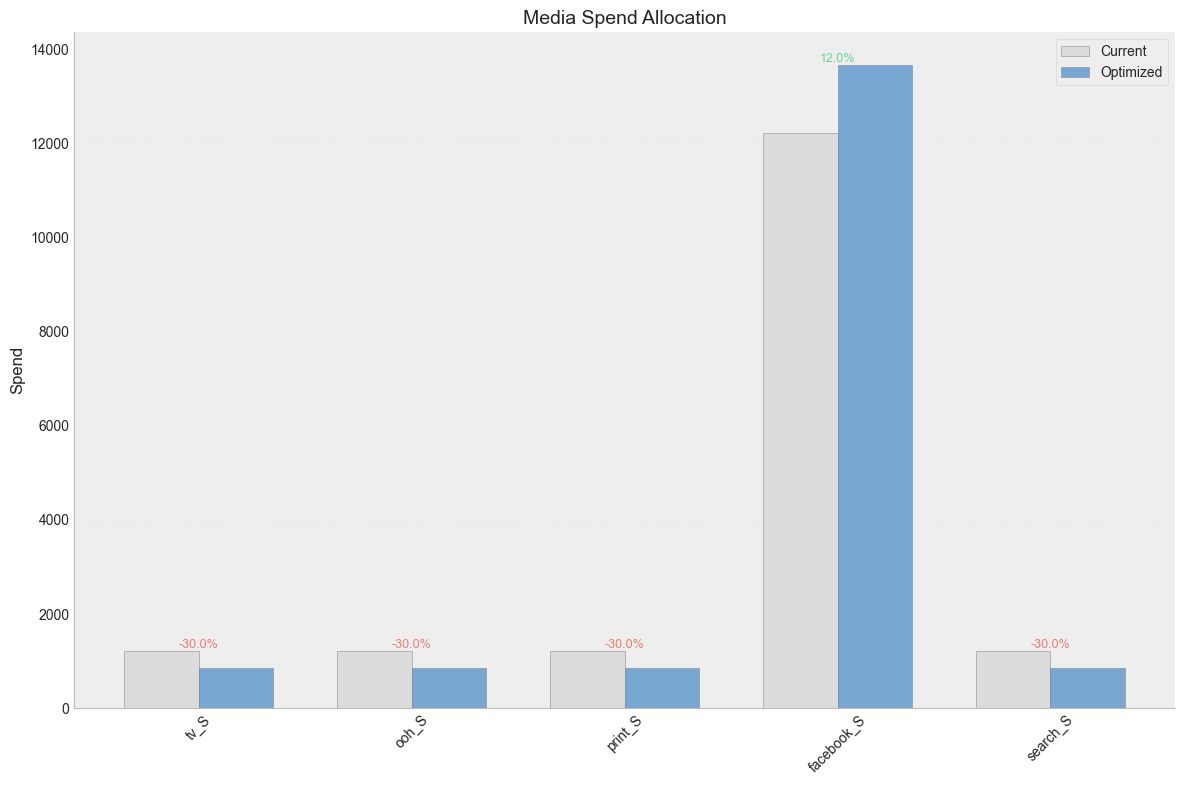

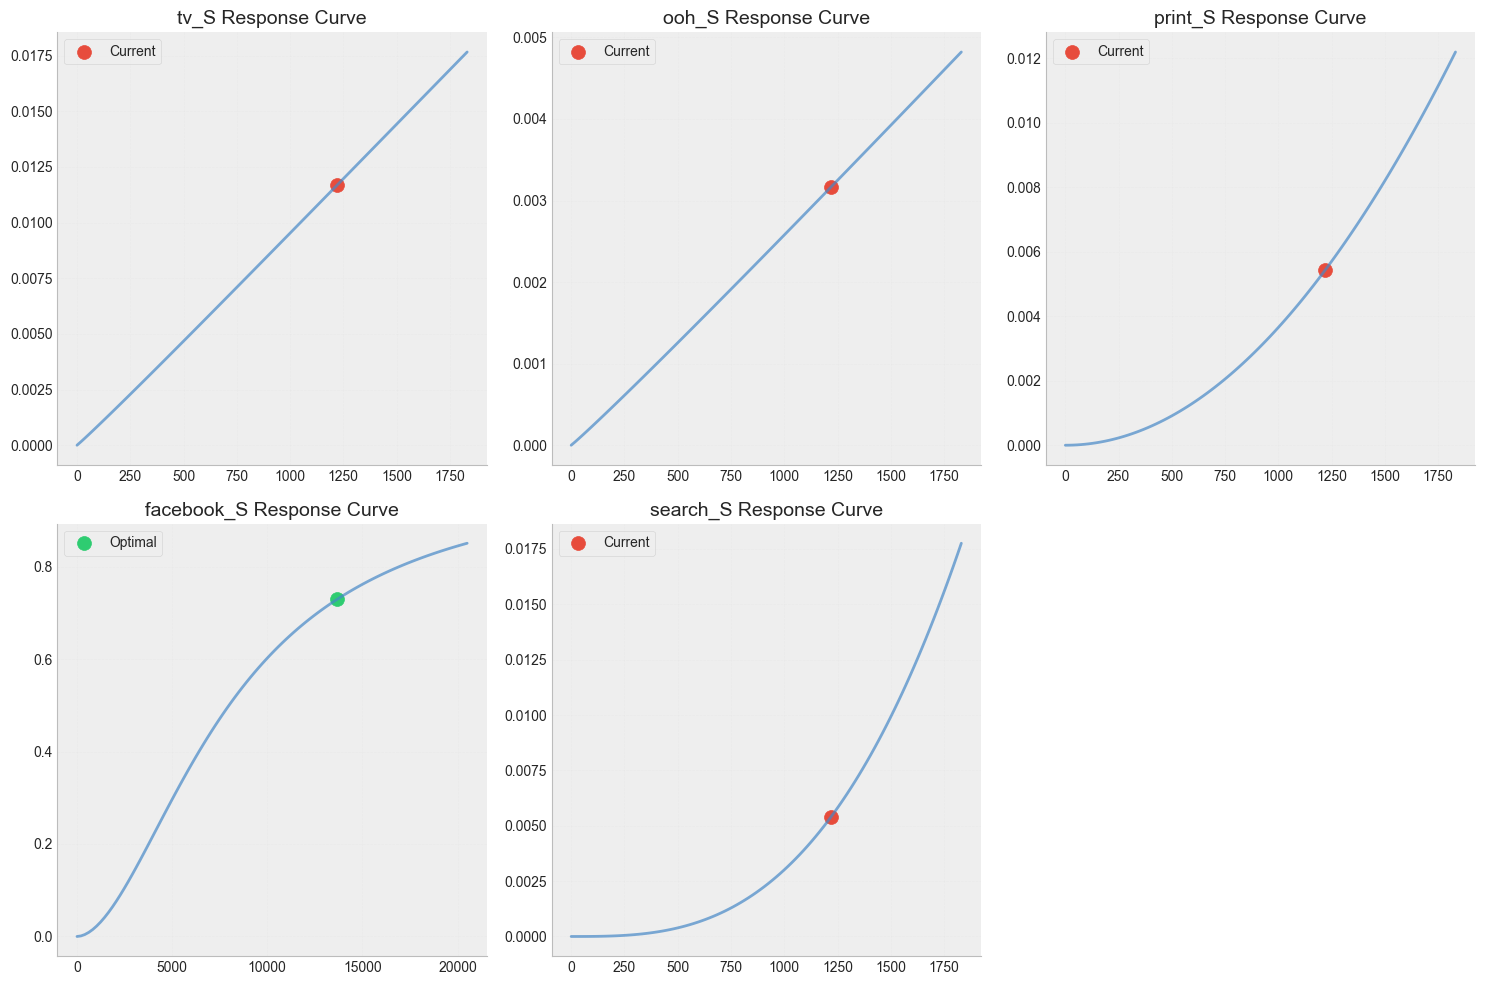

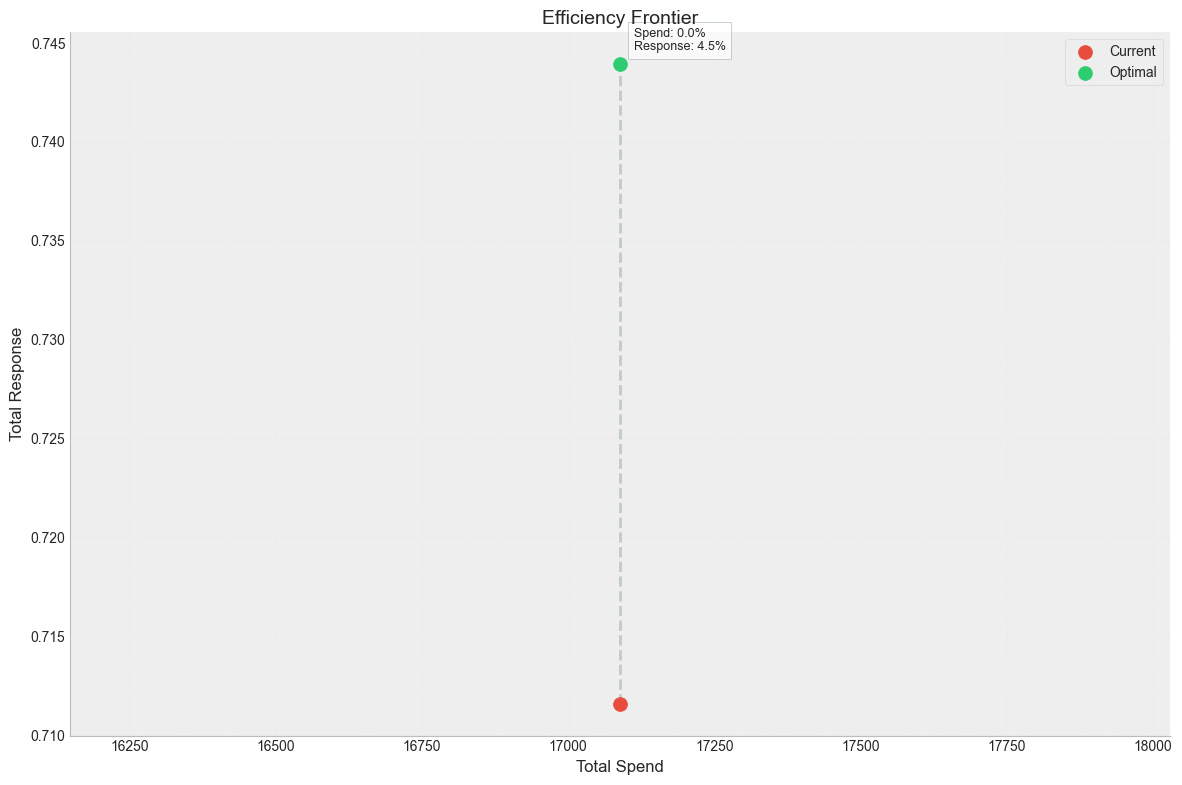

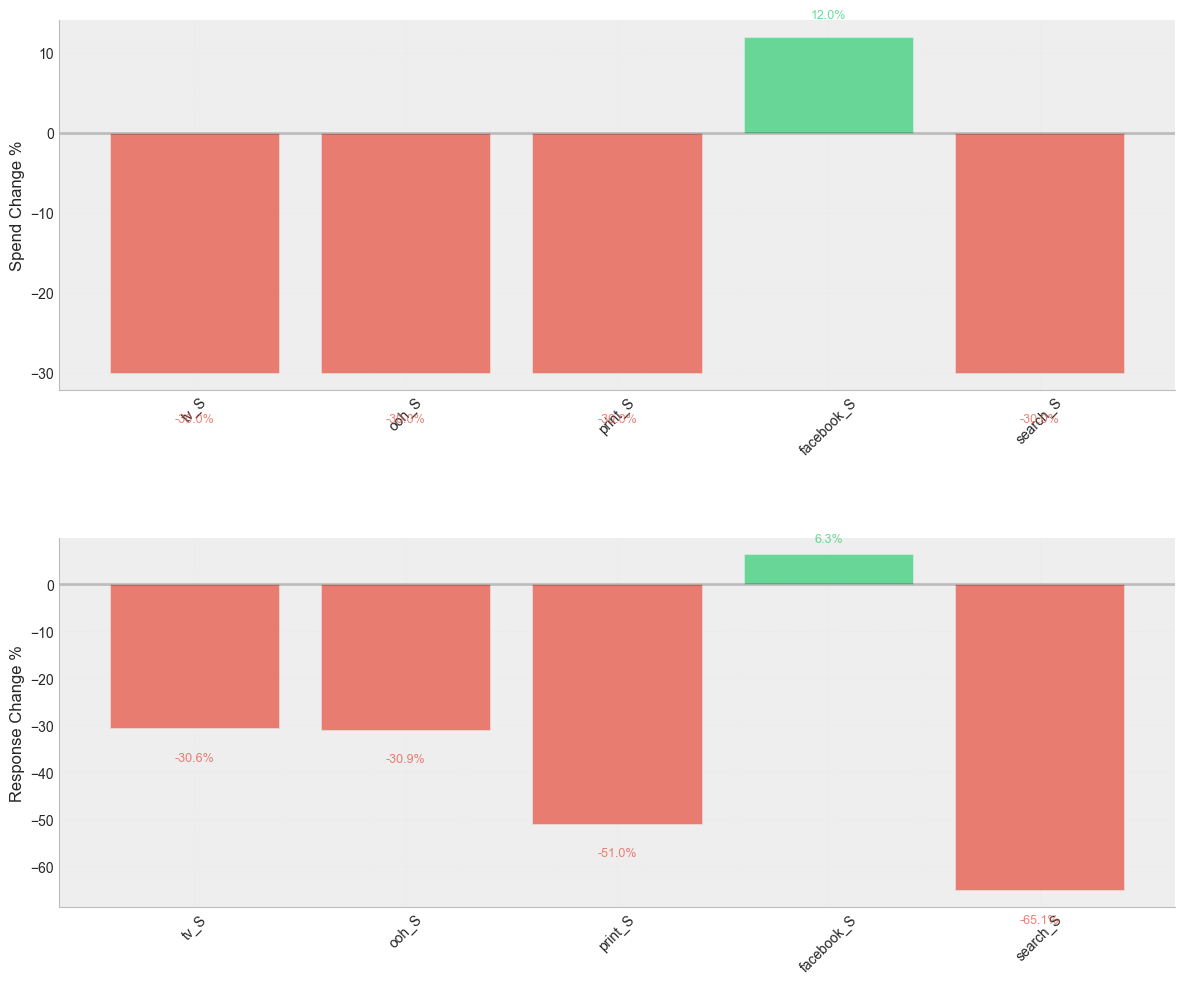

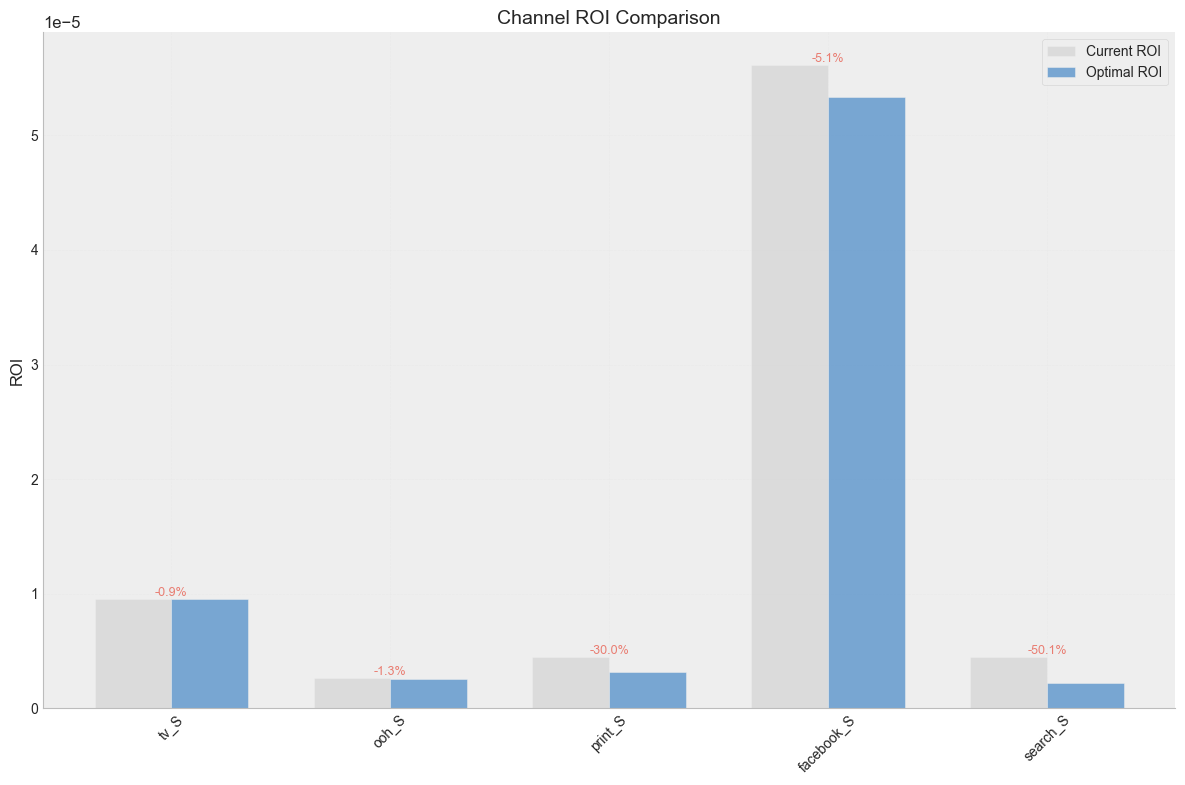

2024-11-18 16:27:39,932 - robyn.visualization.allocator_plotter - INFO - Starting to generate all allocation plots
2024-11-18 16:27:39,932 - robyn.visualization.base_visualizer - INFO - Creating new figure with dimensions 1x1
2024-11-18 16:27:39,943 - robyn.visualization.base_visualizer - INFO - Finalizing figure with tight_layout=True, adjust_spacing=False
2024-11-18 16:27:39,959 - robyn.visualization.allocator_plotter - INFO - Spend allocation plot generated successfully
2024-11-18 16:27:39,960 - robyn.visualization.base_visualizer - INFO - Creating new figure with dimensions 2x3
2024-11-18 16:27:39,998 - robyn.visualization.base_visualizer - INFO - Finalizing figure with tight_layout=True, adjust_spacing=False
2024-11-18 16:27:40,105 - robyn.visualization.allocator_plotter - INFO - Response curves plot generated successfully
2024-11-18 16:27:40,105 - robyn.visualization.base_visualizer - INFO - Creating new figure with dimensions 1x1
2024-11-18 16:27:40,114 - robyn.visualization.bas

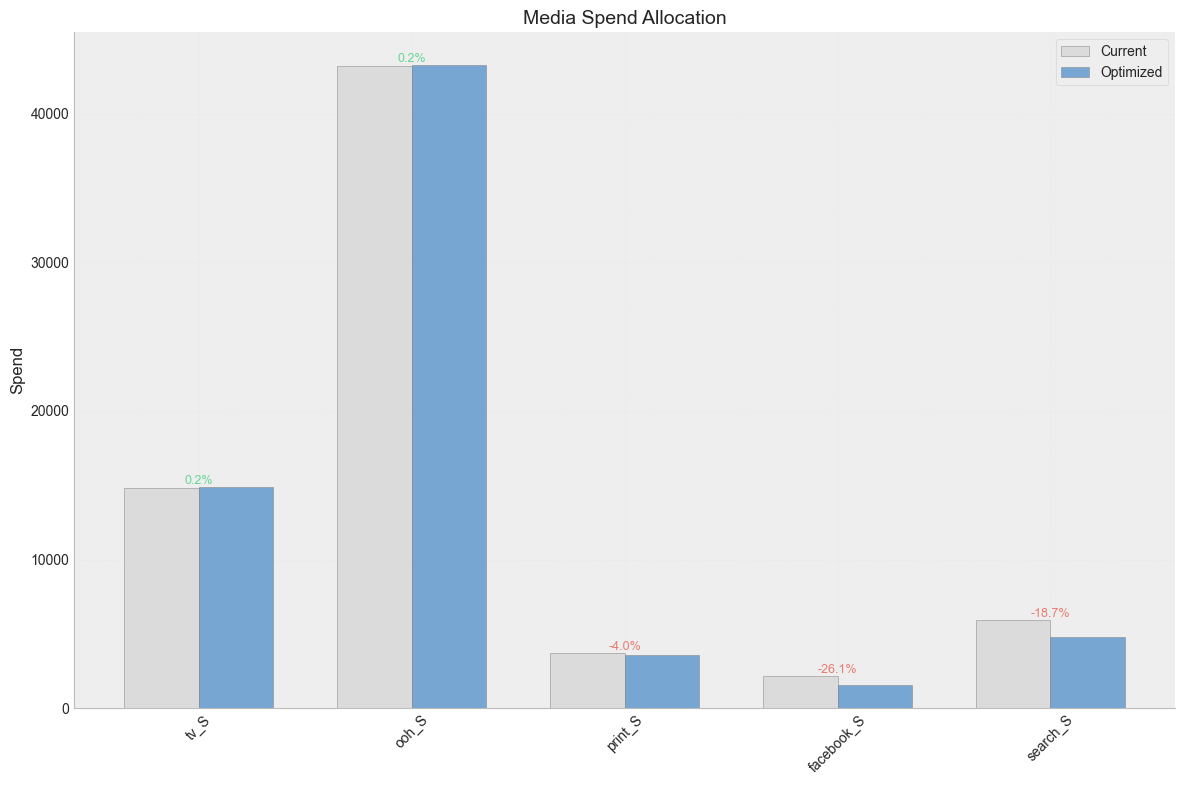

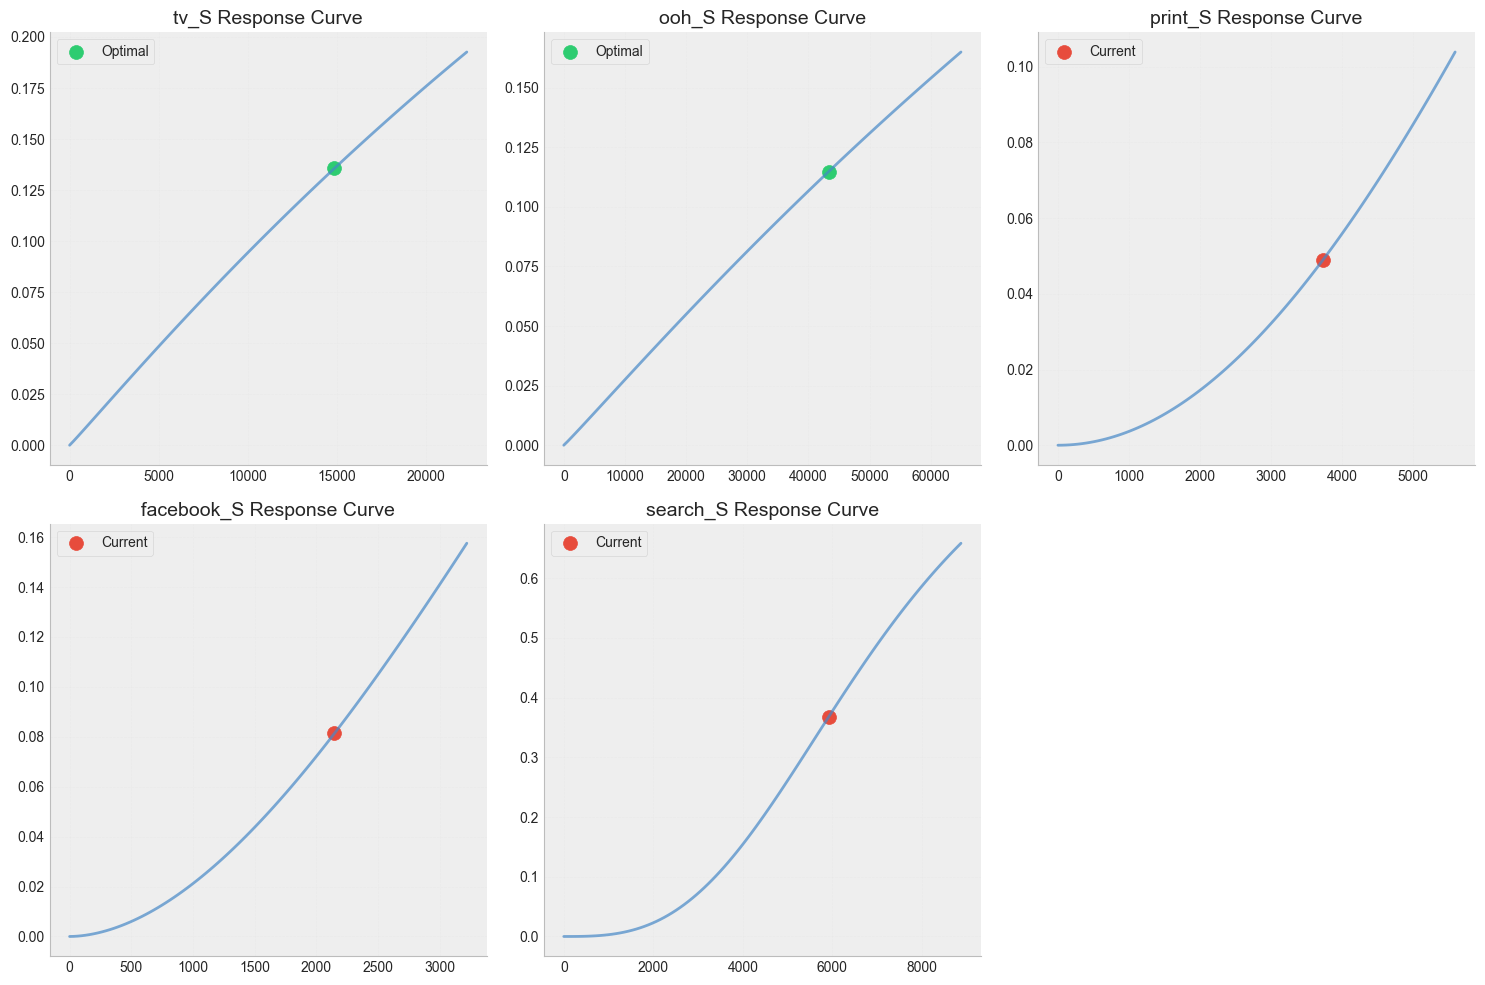

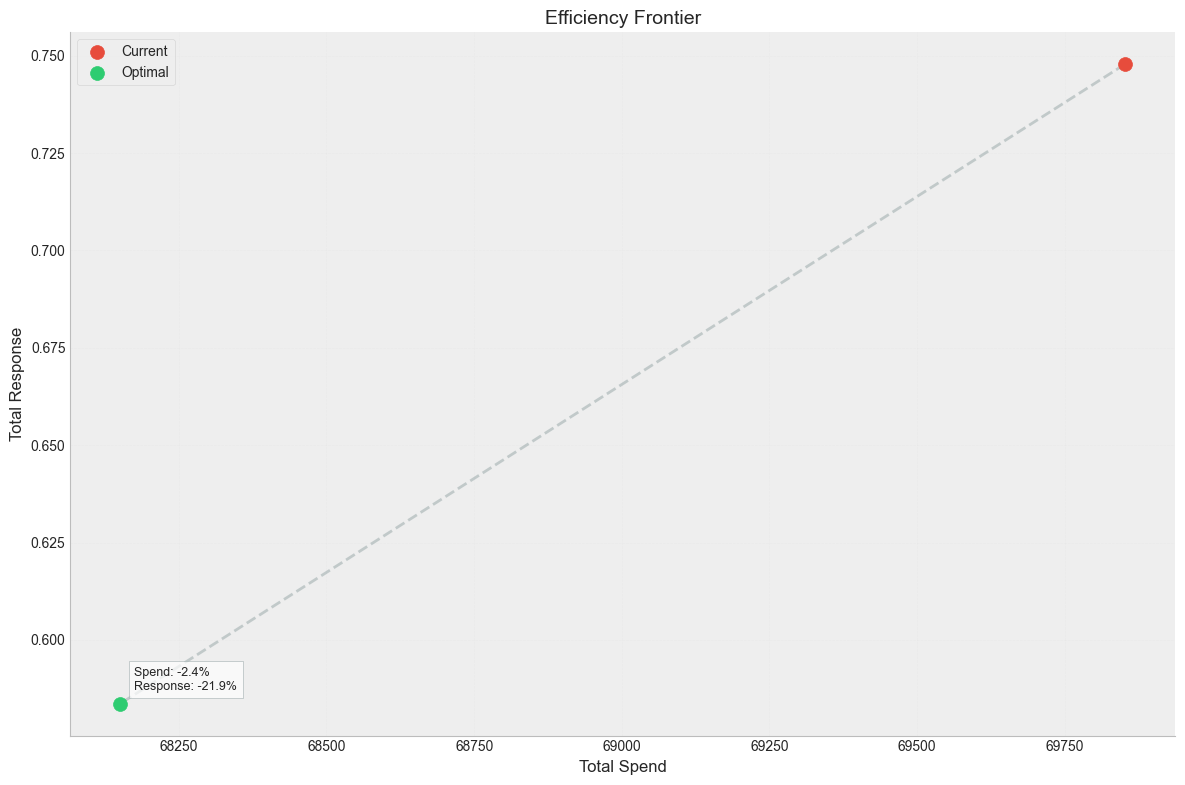

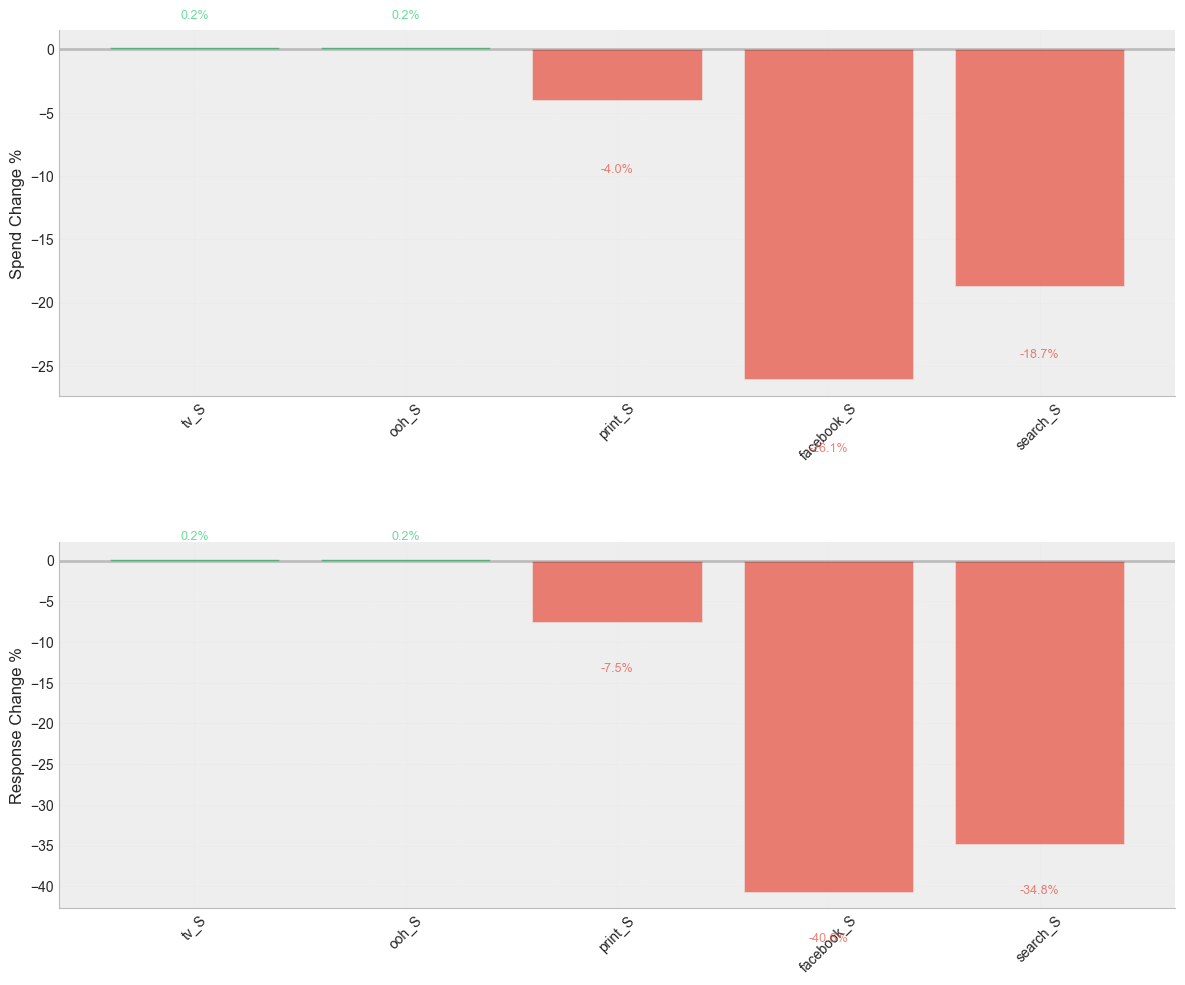

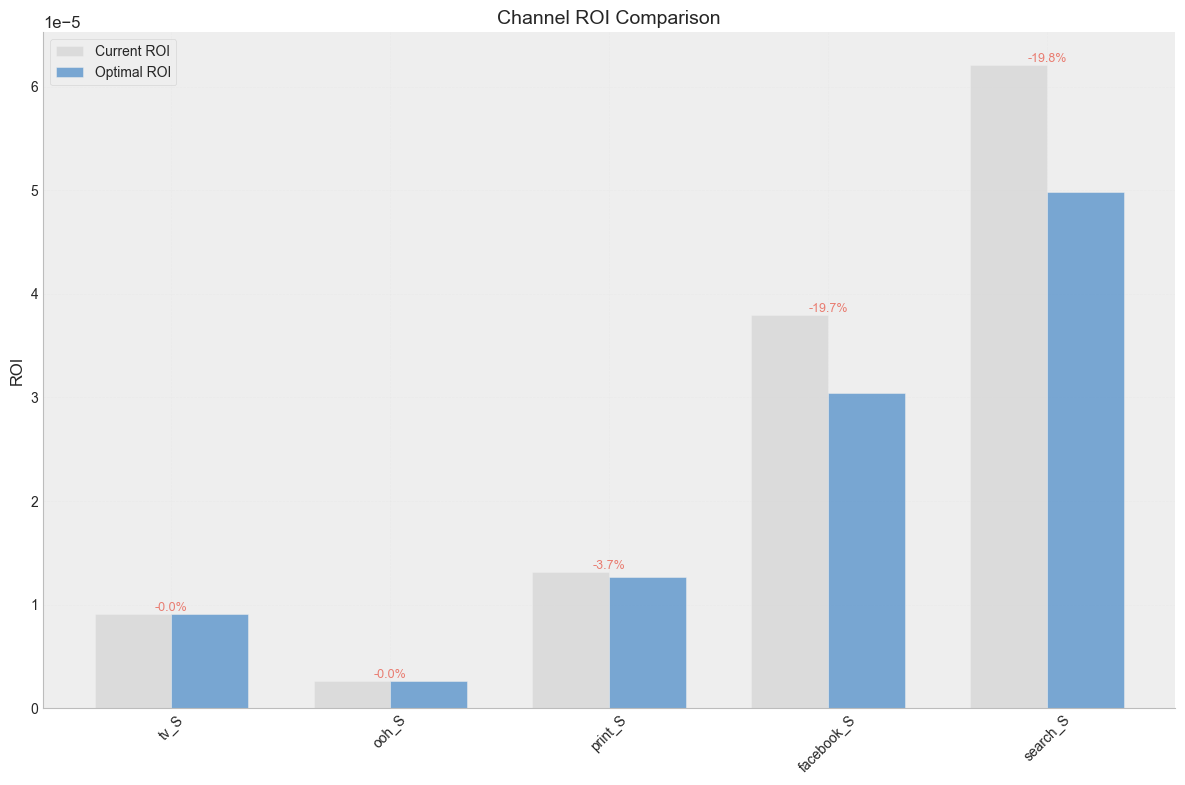

Max Response Scenario Plots:
--------------------------------------------------


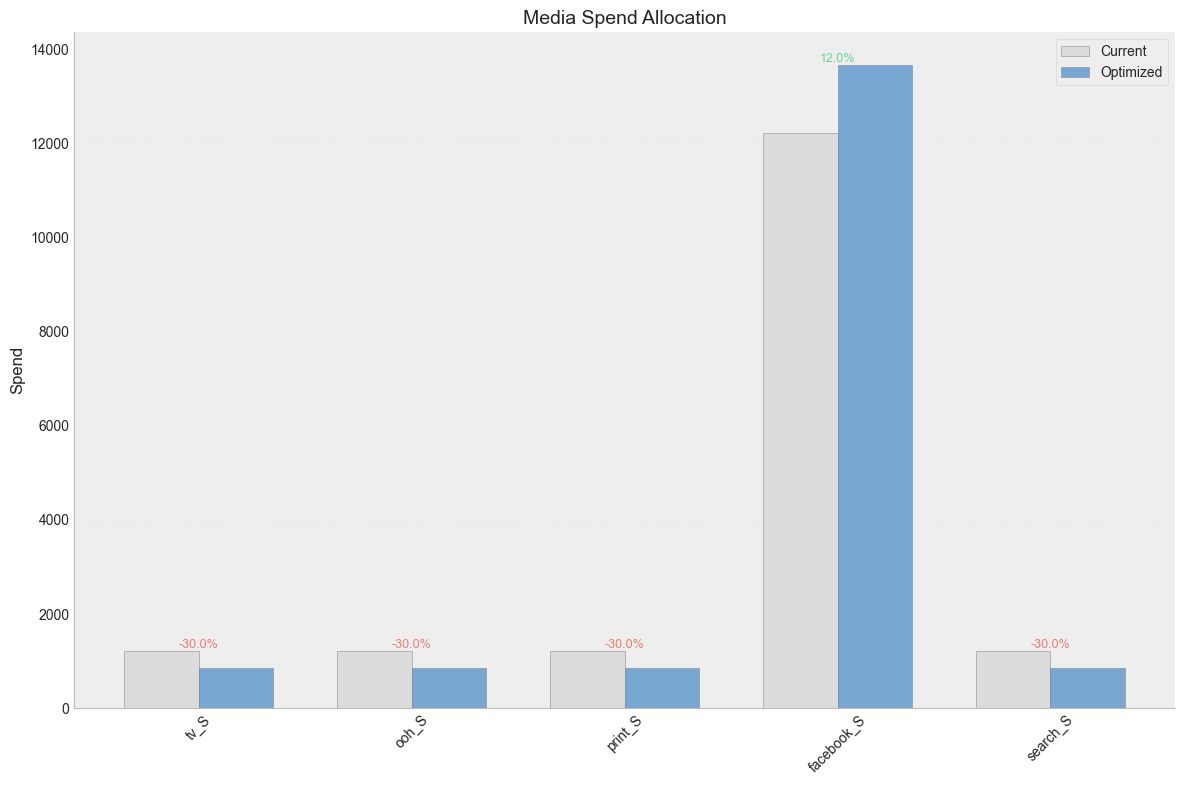

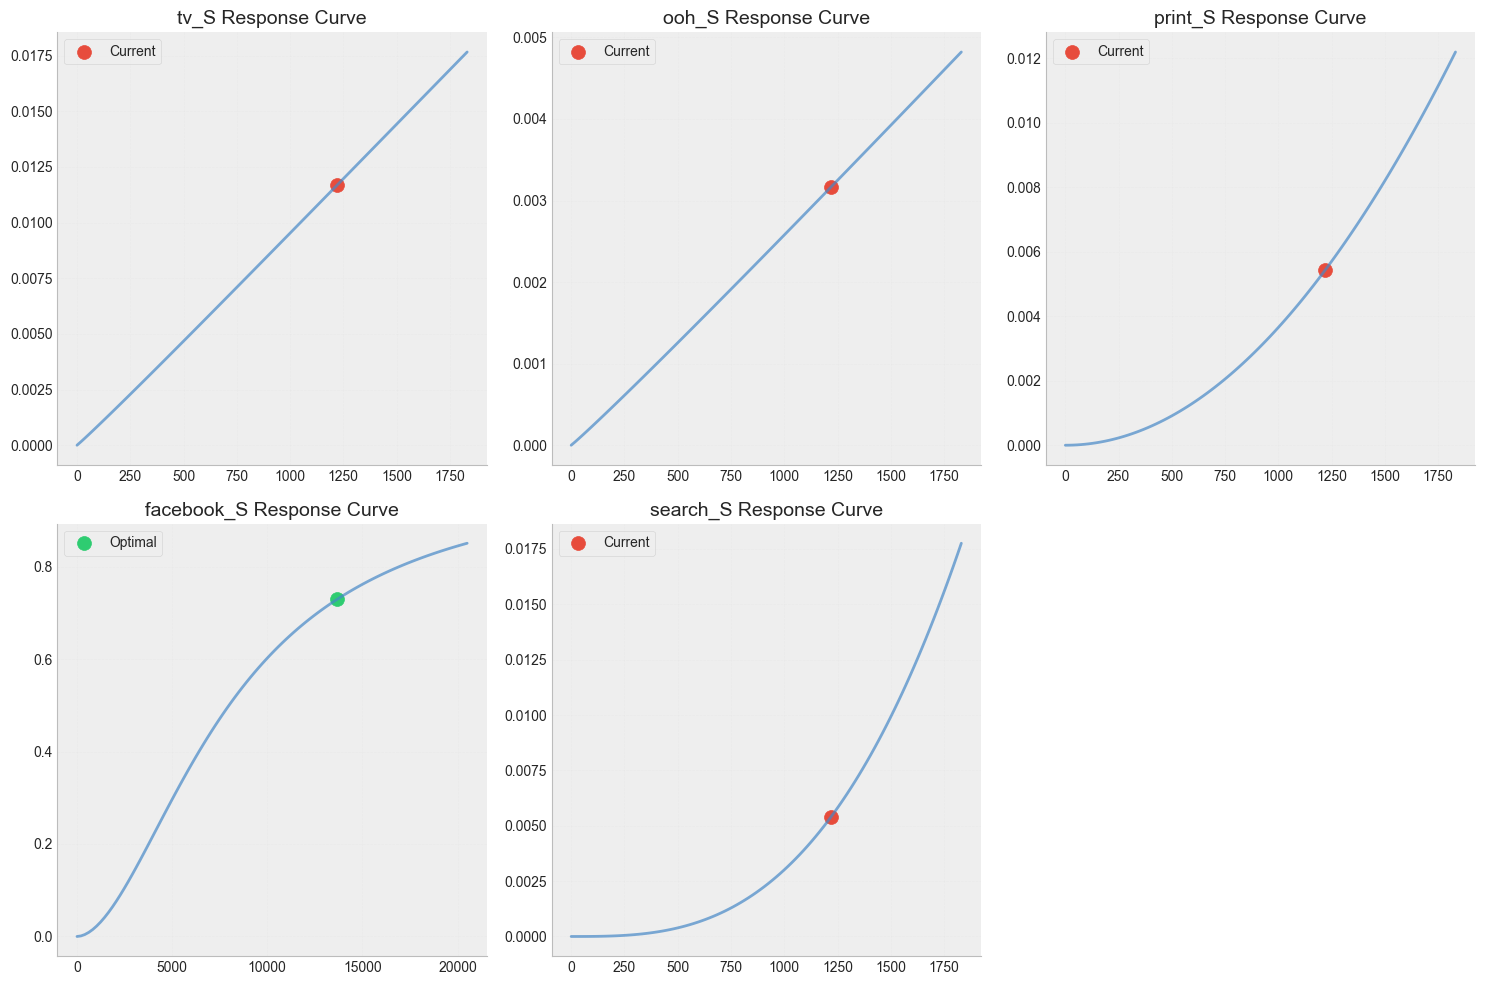

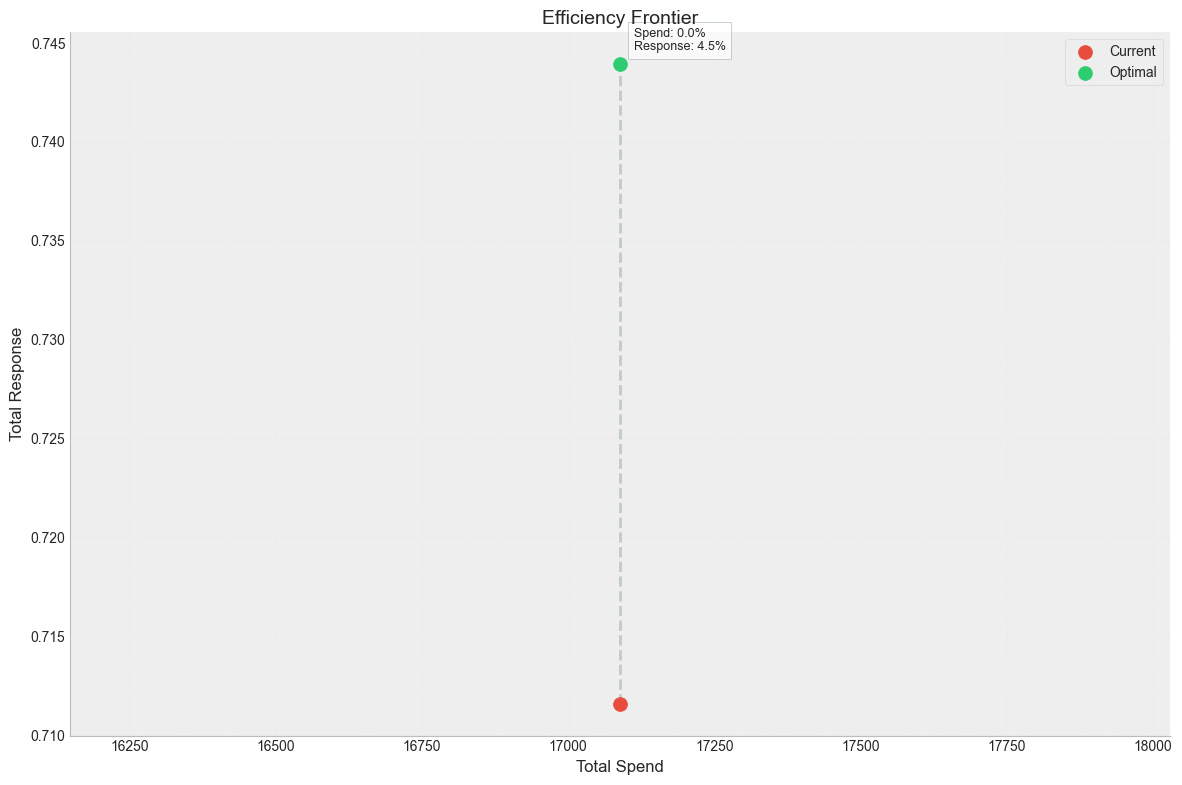

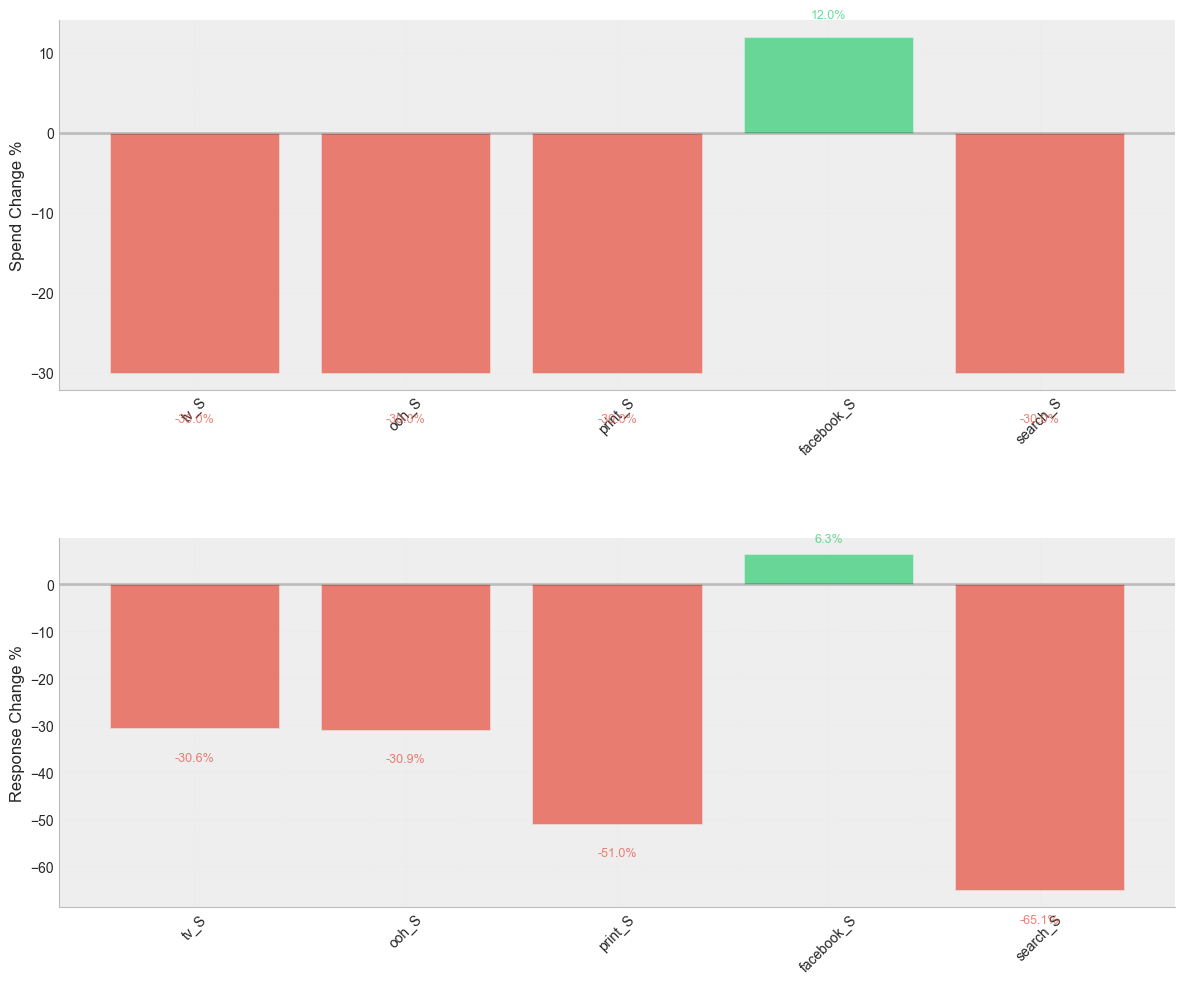

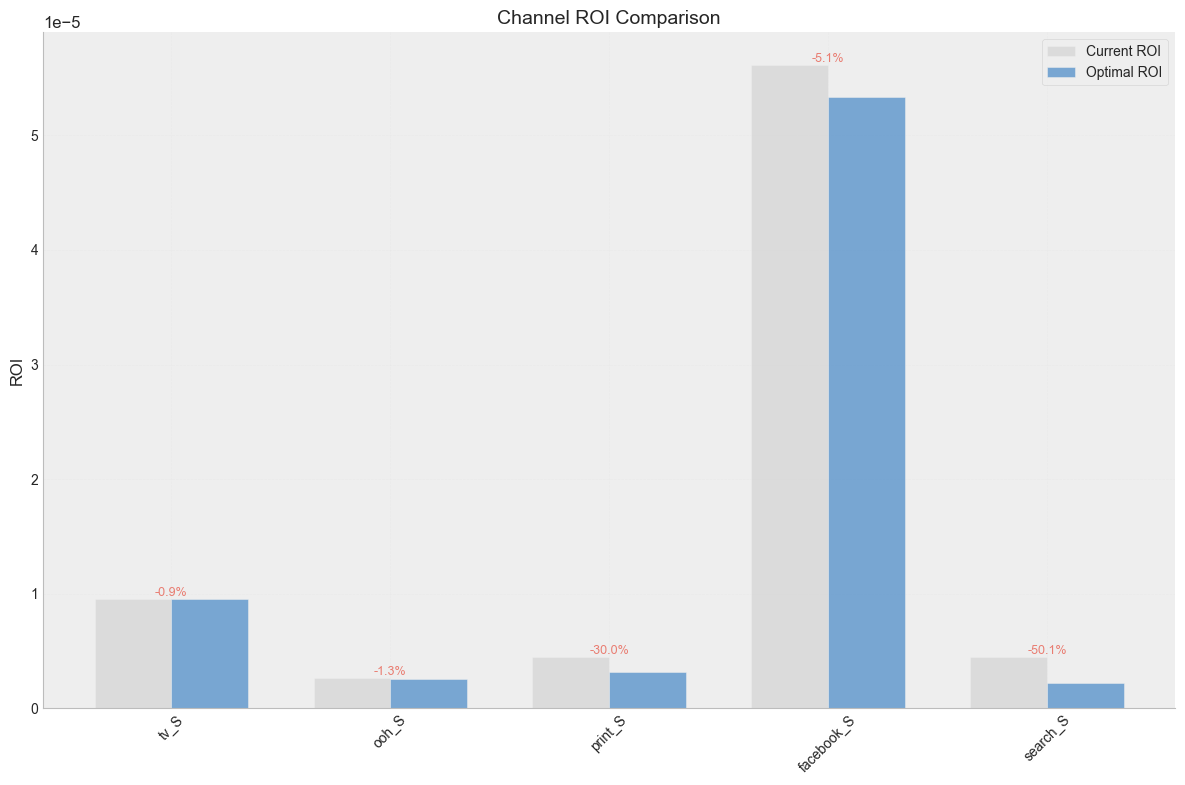


Target Efficiency Scenario Plots:
--------------------------------------------------


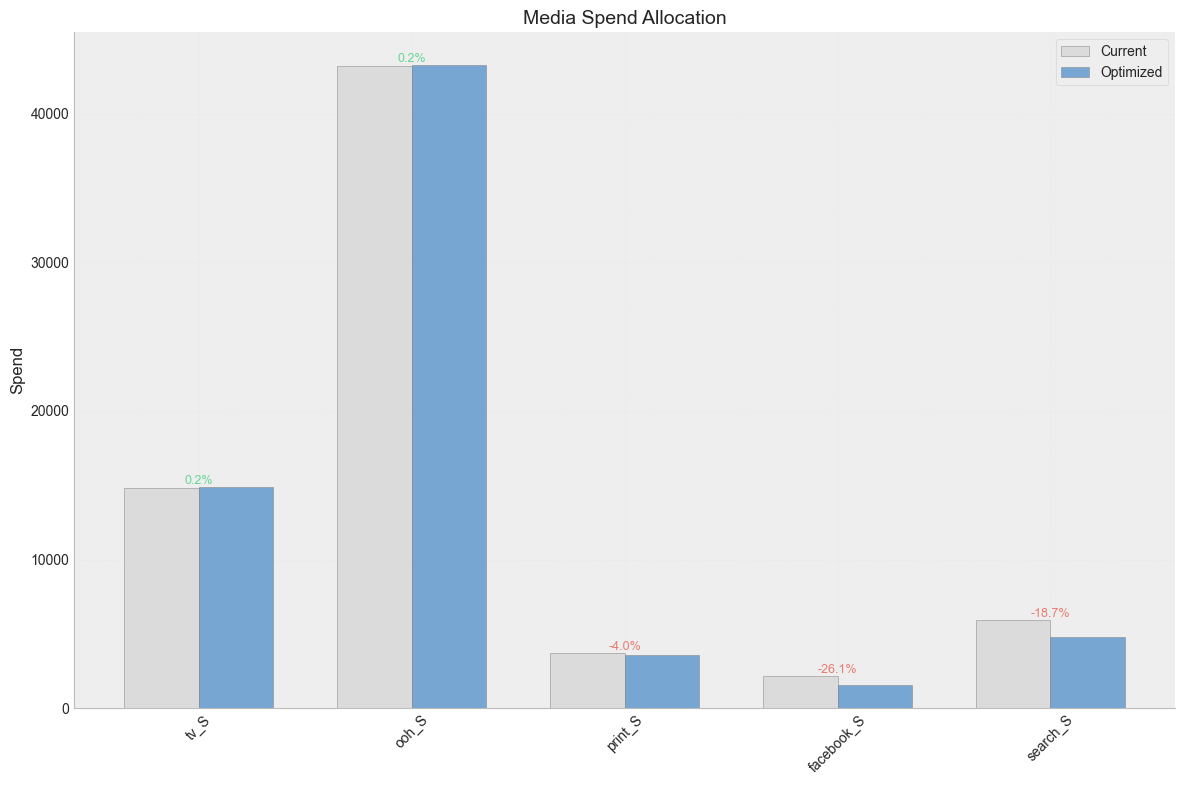

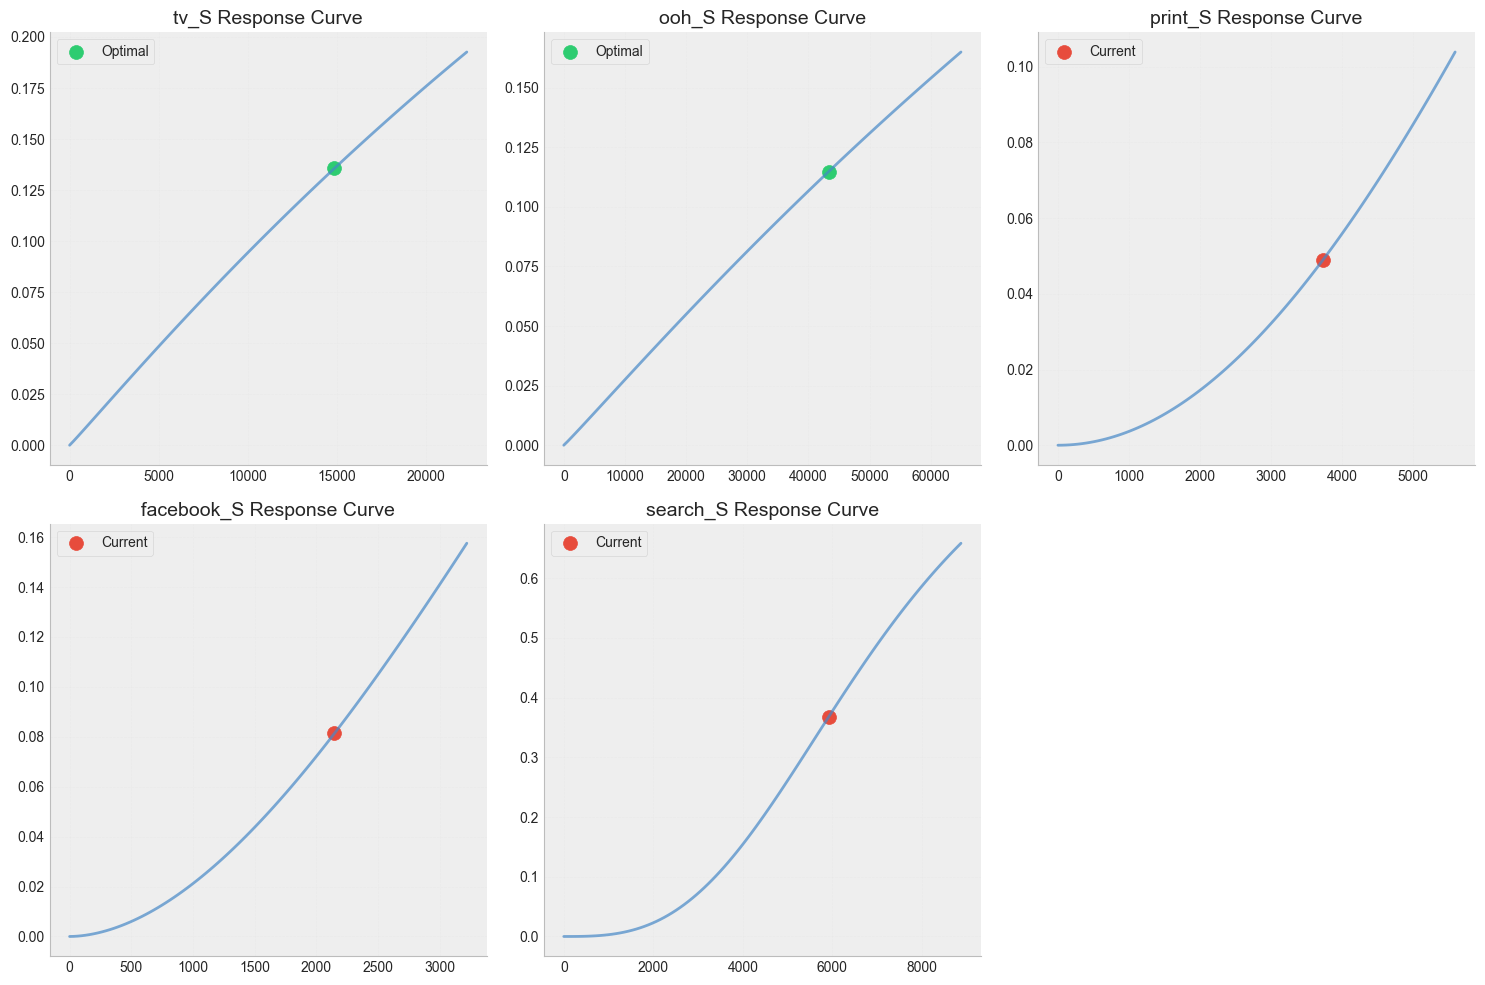

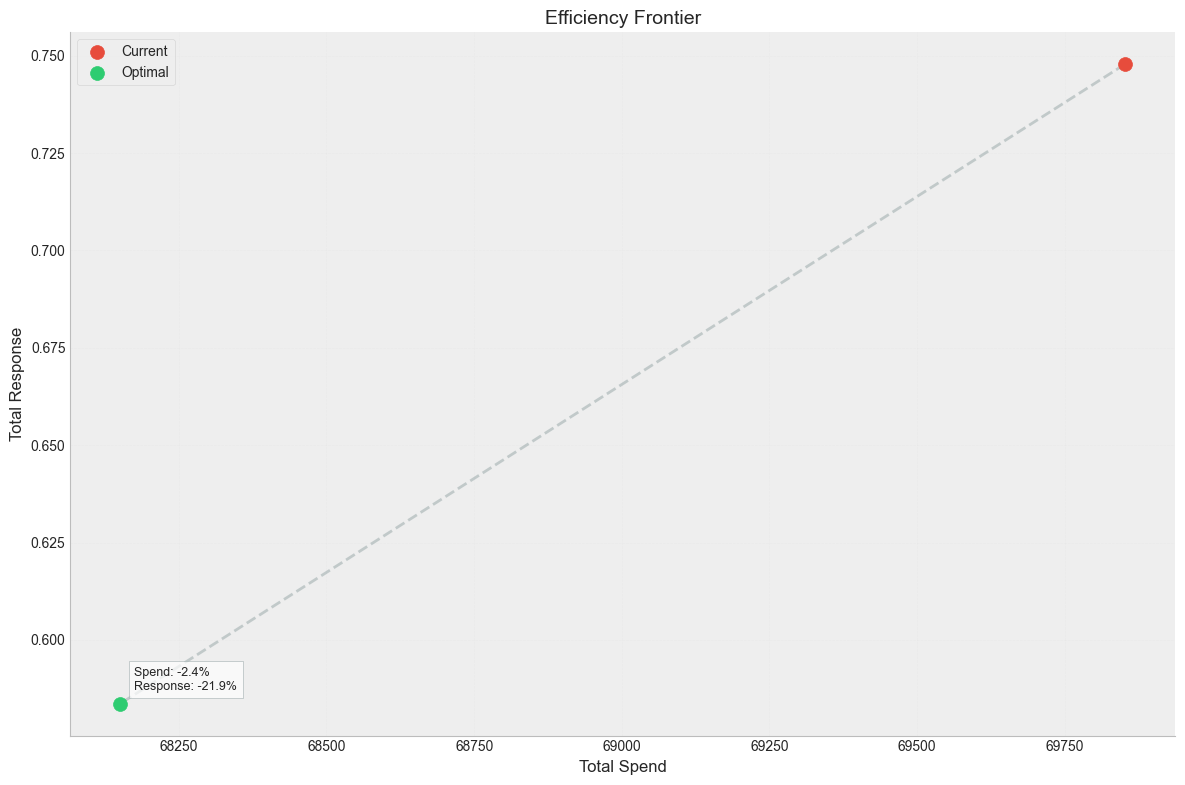

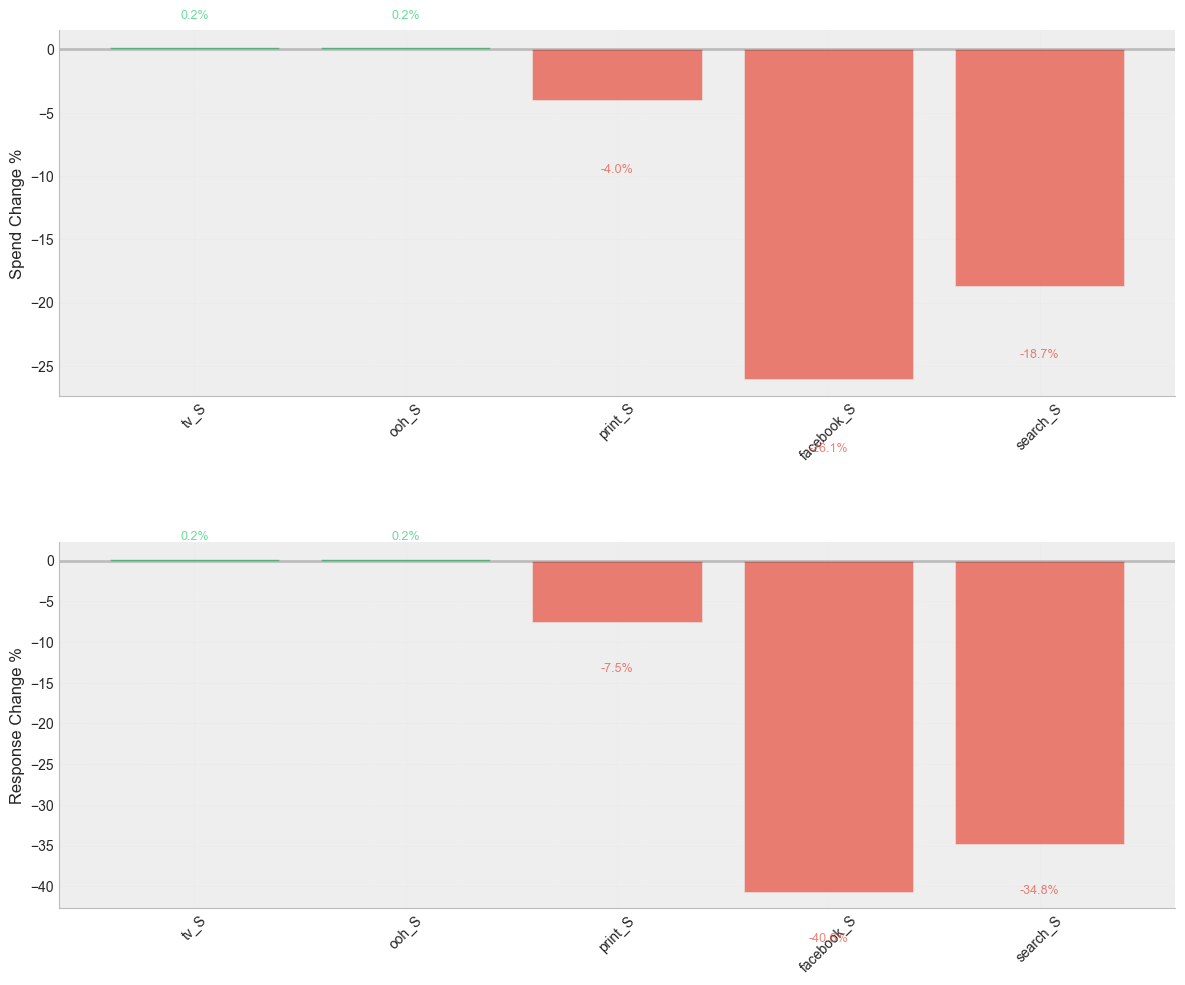

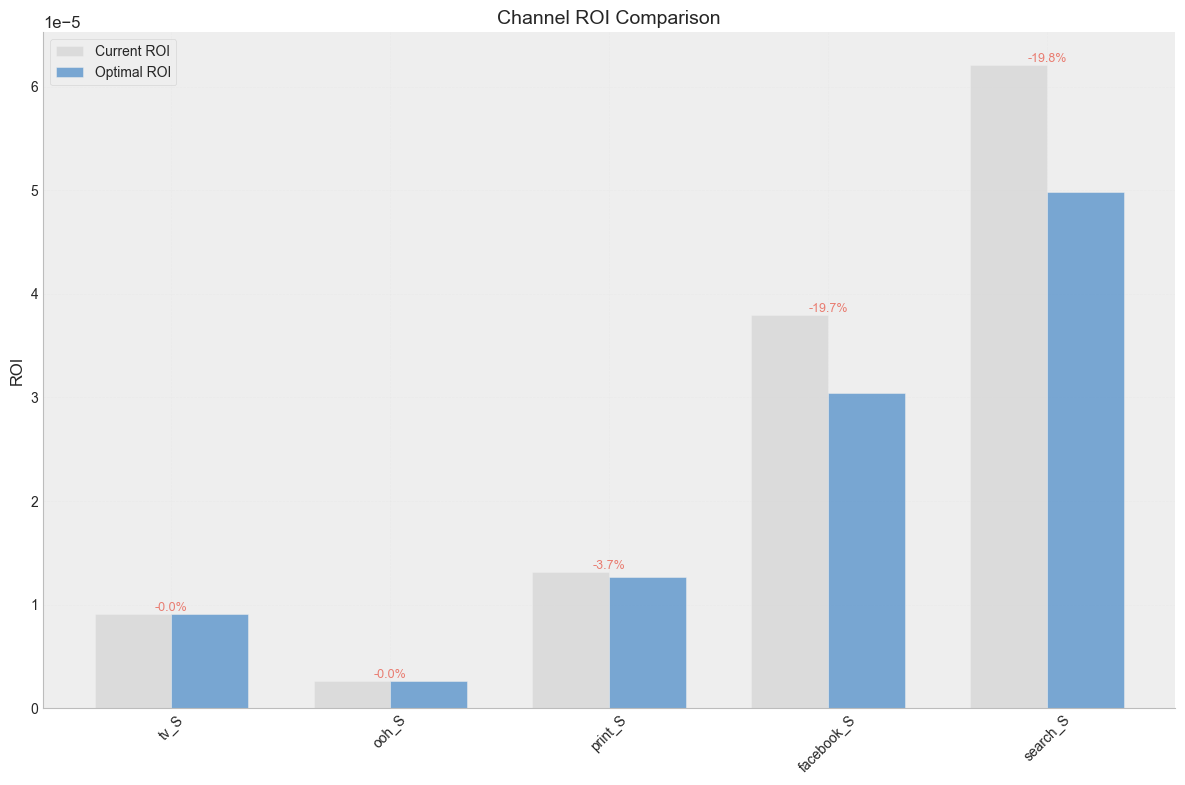

In [32]:
# Create visualizations for each scenario
max_response_plotter = AllocationPlotter(result)
target_efficiency_plotter = AllocationPlotter(result3)

# Generate plots
max_response_plots = max_response_plotter.plot_all()
target_efficiency_plots = target_efficiency_plotter.plot_all()

# Display plots
print("Max Response Scenario Plots:")
print("-" * 50)
for plot_name, fig in max_response_plots.items():
    display(fig)


print("\nTarget Efficiency Scenario Plots:")
print("-" * 50)
for plot_name, fig in target_efficiency_plots.items():
    display(fig)